In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
from pathlib import Path
import itertools
import functools
from collections import namedtuple, Counter, defaultdict
import re
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import read_vocab, PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID, IMAGE_H, IMAGE_W
dataset_name = ("saycam", "childes")[0]
from multimodal.multimodal_saycam_data_module import VOCAB_FILENAME as SAYCAM_VOCAB_FILENAME
from multimodal.text_only_data_module import VOCAB_FILENAME as CHILDES_VOCAB_FILENAME
VOCAB_FILENAMES = {
    "saycam": SAYCAM_VOCAB_FILENAME,
    "childes": CHILDES_VOCAB_FILENAME,
}
VOCAB_FILENAME = VOCAB_FILENAMES[dataset_name]
from ngram import NGramModel
from multimodal.utils import map_structure
from analysis_tools.processing import *
from analysis_tools.utils import *
from analysis_tools.sentences_data import *
from analysis_tools.sentences_utils import *
from analysis_tools.checkpoints import *
from analysis_tools.build_data import *
import analysis_tools.plotting as plotting
import textwrap

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


ZORRO_TXT_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/Zorro/sentences/babyberta/")
ZORRO_TXT_FILES = ZORRO_TXT_DIR.glob('*.txt')
TRAIN_MEAN_IMG_FILE = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal/train_mean_img.pt")


# set default settings for plotting; may change for each plot
figsize = (12, 12)
paper_context = sns.plotting_context('paper')
paper_context.update({
    'font.size': 10.,
    'axes.labelsize': 10.,
    'axes.titlesize': 14.,
    'xtick.labelsize': 8.8,
    'ytick.labelsize': 8.8,
    'legend.fontsize': 8.8,
    'legend.title_fontsize': 9.6,
})
unticked_relation_style = sns.axes_style('white')
unticked_relation_style.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
})
font = 'serif'
sns.set_theme(
    #context=paper_context,
    style=unticked_relation_style,
    #palette=sns.color_palette('tab20'),
    font='serif',
    rc={
        'figure.figsize': figsize,
    }
)

np.set_printoptions(suppress=True, precision=2, linewidth=120)
pd.options.display.width = 120

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.
plot_format = 'pdf'
saving_fig = False

if saving_fig:
    def _save_fig(fname, format='png'):
        print(f'saving plot {fname}')
        plt.savefig(f'plots/{fname}.{format}', transparent=True)
        plt.clf()
    plotting.output_fig = functools.partial(_save_fig, format=plot_format)
else:
    plotting.output_fig = lambda fname: plt.show()

output_fig = plotting.output_fig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def sentence_pair_in_vocab(sentence_pair, vocab):
    for sentence in sentence_pair:
        if not all(str(token) in vocab for token in sentence):
            return False
    return True


phenomenon_name_aliases = {
    'agreement_determiner_noun': 'determiner-noun_agreement',
    'agreement_subject_verb'   : 'subject-verb_agreement'   ,
}


def get_data_name_from_paradigm_name(
    paradigm_name,
    sep='-',
    replace_underline_by=' ',
    phenomenon_name_aliases=phenomenon_name_aliases,
):
    partition_of_paradigm_name = paradigm_name.rpartition(sep)
    assert partition_of_paradigm_name[1] == sep
    phenomenon_name, _paradigm_name = partition_of_paradigm_name[0], partition_of_paradigm_name[2]
    phenomenon_name = phenomenon_name_aliases.get(phenomenon_name, phenomenon_name)
    data_name = phenomenon_name, _paradigm_name
    if replace_underline_by is not None:
        data_name = tuple(name.replace('_', replace_underline_by) for name in data_name)
    return data_name

In [3]:
# get my vocab
saycam_vocab = read_vocab(SAYCAM_VOCAB_FILENAME)
childes_vocab = read_vocab(CHILDES_VOCAB_FILENAME)
childes_yulu_vocab = read_vocab(CHILDES_VOCAB_FILENAME.parent/"vocab_yulu.json")
intersection_vocab = {word: idx for word, idx in saycam_vocab.items() if word in childes_yulu_vocab}
my_vocab = saycam_vocab
my_vocab_size = len(my_vocab)
print(f'{my_vocab_size = }')
word2idx = my_vocab
idx2word = [None] * my_vocab_size
for word, idx in word2idx.items():
    idx2word[idx] = word
idx2word = np.array(idx2word)

# get Zorro data
zorro_data = {}
zorro_vocab = Counter()

paradigm_name_to_data_name = {}

for zorro_txt_file in ZORRO_TXT_FILES:
    paradigm_name = zorro_txt_file.stem
    data_name = get_data_name_from_paradigm_name(paradigm_name)
    paradigm_name_to_data_name[paradigm_name] = data_name
    print(f'processing {paradigm_name} ...', flush=True)

    with open(zorro_txt_file, 'r') as f:
        sentences = pd.Series(tokenize(line.strip() for line in f))

    zorro_data[data_name] = sentences

    zorro_vocab.update(map(str, itertools.chain.from_iterable(sentences)))

data_name_to_paradigm_name = {data_name: paradigm_name for paradigm_name, data_name in paradigm_name_to_data_name.items()}

# Zorro vocab
zorro_vocab = Counter(dict(sorted(
    zorro_vocab.items(),
    key = lambda item: (-item[1], item[0])
)))
zorro_vocab_size = len(zorro_vocab)
print(f'{zorro_vocab_size = }')
print('words in zorro vocab:')
for word, freq in list(zorro_vocab.items())[:100]:
    print(f'{word:10} {freq:6}')

# Zorro vocab compared to my vocab

def print_in_vocab_info(tested_vocab: Counter, vocab: Counter, tested_vocab_name: str, vocab_name: str):
    in_vocab_cnt = 0
    print(f'{tested_vocab_name} words not in {vocab_name}:')
    for word, freq in tested_vocab.items():
        if word in vocab:
            in_vocab_cnt += 1
        else:
            print(word)
    print(f'{frac_format(in_vocab_cnt, len(tested_vocab))} in {vocab_name}')

print_in_vocab_info(zorro_vocab, my_vocab, 'zorro vocab', 'my vocab')

# filter Zorro data
filter_masks = {}

save_filtered_to_path = Path('/misc/vlgscratch4/LakeGroup/shared_data/Zorro/sentences/saycam-s-wentao-childes-sarah-yulu-intersection')
save_filtered_to_path.mkdir(exist_ok=True)

for data_name, sentences in zorro_data.items():
    n_total = 0

    print('out-of-my vocab sentence examples:')
    sentence_pairs = pd.Series(paired(sentences))
    filter_mask = sentence_pairs.map(lambda sentence_pair: sentence_pair_in_vocab(sentence_pair, intersection_vocab))
    for sentence_pair in sentence_pairs[~filter_mask].iloc[:1]:
        for sentence in sentence_pair:
            print(untokenize(sentence))
        print(
            'OOV tokens:',
            ' '.join(
                str(token)
                for sentence in sentence_pair
                for token in sentence
                if str(token) not in my_vocab
            )
        )

    print(f'{data_name}: {frac_format(filter_mask.sum(), len(filter_mask))}')

    filter_masks[data_name] = filter_mask

    if True and filter_mask.sum():
        paradigm_name = data_name_to_paradigm_name[data_name]
        filename = save_filtered_to_path / f"{paradigm_name}.txt"
        print(f"writing filtered sentences to {filename} ...")
        with open(filename, 'w') as f:
            for sentence_pair in sentence_pairs[filter_mask]:
                for sentence in sentence_pair:
                    print(untokenize(sentence), file=f)

my_vocab_size = 2350
processing agreement_determiner_noun-across_1_adjective ...
processing agreement_determiner_noun-between_neighbors ...
processing agreement_subject_verb-across_prepositional_phrase ...
processing agreement_subject_verb-across_relative_clause ...
processing agreement_subject_verb-in_question_with_aux ...
processing agreement_subject_verb-in_simple_question ...
processing anaphor_agreement-pronoun_gender ...
processing argument_structure-dropped_argument ...
processing argument_structure-swapped_arguments ...
processing argument_structure-transitive ...
processing binding-principle_a ...
processing case-subjective_pronoun ...
processing ellipsis-n_bar ...
processing filler-gap-wh_question_object ...
processing filler-gap-wh_question_subject ...
processing irregular-verb ...
processing island-effects-adjunct_island ...
processing island-effects-coordinate_structure_constraint ...
processing local_attractor-in_question_with_aux ...
processing npi_licensing-matrix_quest

In [4]:
print_in_vocab_info(childes_yulu_vocab, saycam_vocab, 'childes yulu vocab', 'saycam vocab')
print_in_vocab_info(saycam_vocab, childes_yulu_vocab, 'saycam vocab', 'childes yulu vocab')
#print_in_vocab_info(childes_vocab, saycam_vocab, 'childes vocab', 'saycam vocab')
#print_in_vocab_info(saycam_vocab, childes_vocab, 'saycam vocab', 'childes vocab')

childes yulu vocab words not in saycam vocab:
abc
abcs
accident
accomplishment
act
address
advertisement
afternoon
afterward
afterwards
age
ai
aid
allegiance
alligator
alphabets
angels
animal
ann
anne
annie
answer
answers
anybody
apron
arabesque
arthur
ashtray
asking
august
auntie
avenue
avon
awfully
awoh
backyard
bags
bahbah
bakes
bald
ballerina
ballet
baloney
bam
bandage
bandaid
bandaids
bangs
bank
barbara
barnes
barney
barron
baseball
baskets
bathing
bathingsuit
baths
batman
batteries
battery
bawbo
baxter
beard
beatle
beatles
beauty
beaver
becauses
bedroom
bedtime
beef
beep
begin
begins
behave
believe
belong
belt
besides
bessy
beth
betty
biggest
bill
billy
blackboard
blame
blanche
bleed
bless
blind
blitzen
blonde
board
bob
bobby
bobo
bobos
bogeyman
bond
bone
bones
bonnie
boofoo
born
borrow
boss
boston
bother
bow
bowie
bozo
bracelet
brand-new
breaking
breath
bride
brighams
bringing
brings
brother
brothers
brownie
buba
bubba
bubblebath
bugs
bumble
bumped
buns
bureau
burke
burn
bushel


In [5]:
# build datasets
datasets = {
    data_name: SentencesDataset(sentences, my_vocab)
    for data_name, sentences in zorro_data.items()
}

my_batch_size = 256


# load model from checkpoint

# select from list of checkpoints
if dataset_name == "childes":
    names = ["LSTM 0"]
else:
    names = [
        "LSTM",
        "Captioning LSTM",
        "CBOW",
        "unigram", "bigram", #"trigram", "4-gram",
    ]
groups = {name: all_groups[name] for name in names}
ori_names = list(itertools.chain.from_iterable(groups.values()))
checkpoint_paths = all_checkpoint_paths[dataset_name]

ori_models = {}

my_data = None

for ori_name in ori_names:
    checkpoint_path = checkpoint_paths[ori_name]

    if "gram" in checkpoint_path:
        ngram_model = build_ngram_model(int(checkpoint_path.split('-')[0]), my_vocab_size, my_data.train_dataloader())
        model = ngram_model

    else:
        print(f"load model from {checkpoint_path}")
        lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
        lit_model.to(device)
        lit_model.eval()
        model = lit_model

        if my_data is None:
            # build data and vocab according to the model
            my_data, args = build_data(args=lit_model.args, return_args=True)
            dataset_name = args.dataset

        else:
            assert lit_model.args["dataset"] == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

    ori_models[ori_name] = model

load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt`
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
  rank_zero_warn(
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using 

Using base transforms
Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created. Skipping this step.
Shuffled training metadata file has already been created. Skipping this step.
Evaluation frames have already been filtered. Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Filtered evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Vocabulary file already exists. Skipp

Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt`


load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt
load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=28.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=28.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt`


load model from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt
load model from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=42.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=42.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=38.ckpt`


load model from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=38.ckpt
load model from checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_0/epoch=31.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_0/epoch=31.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_1/epoch=65.ckpt`


load model from checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_1/epoch=65.ckpt
load model from checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_2/epoch=58.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_2/epoch=58.ckpt`
100%|██████████| 2108/2108 [00:18<00:00, 112.03it/s]


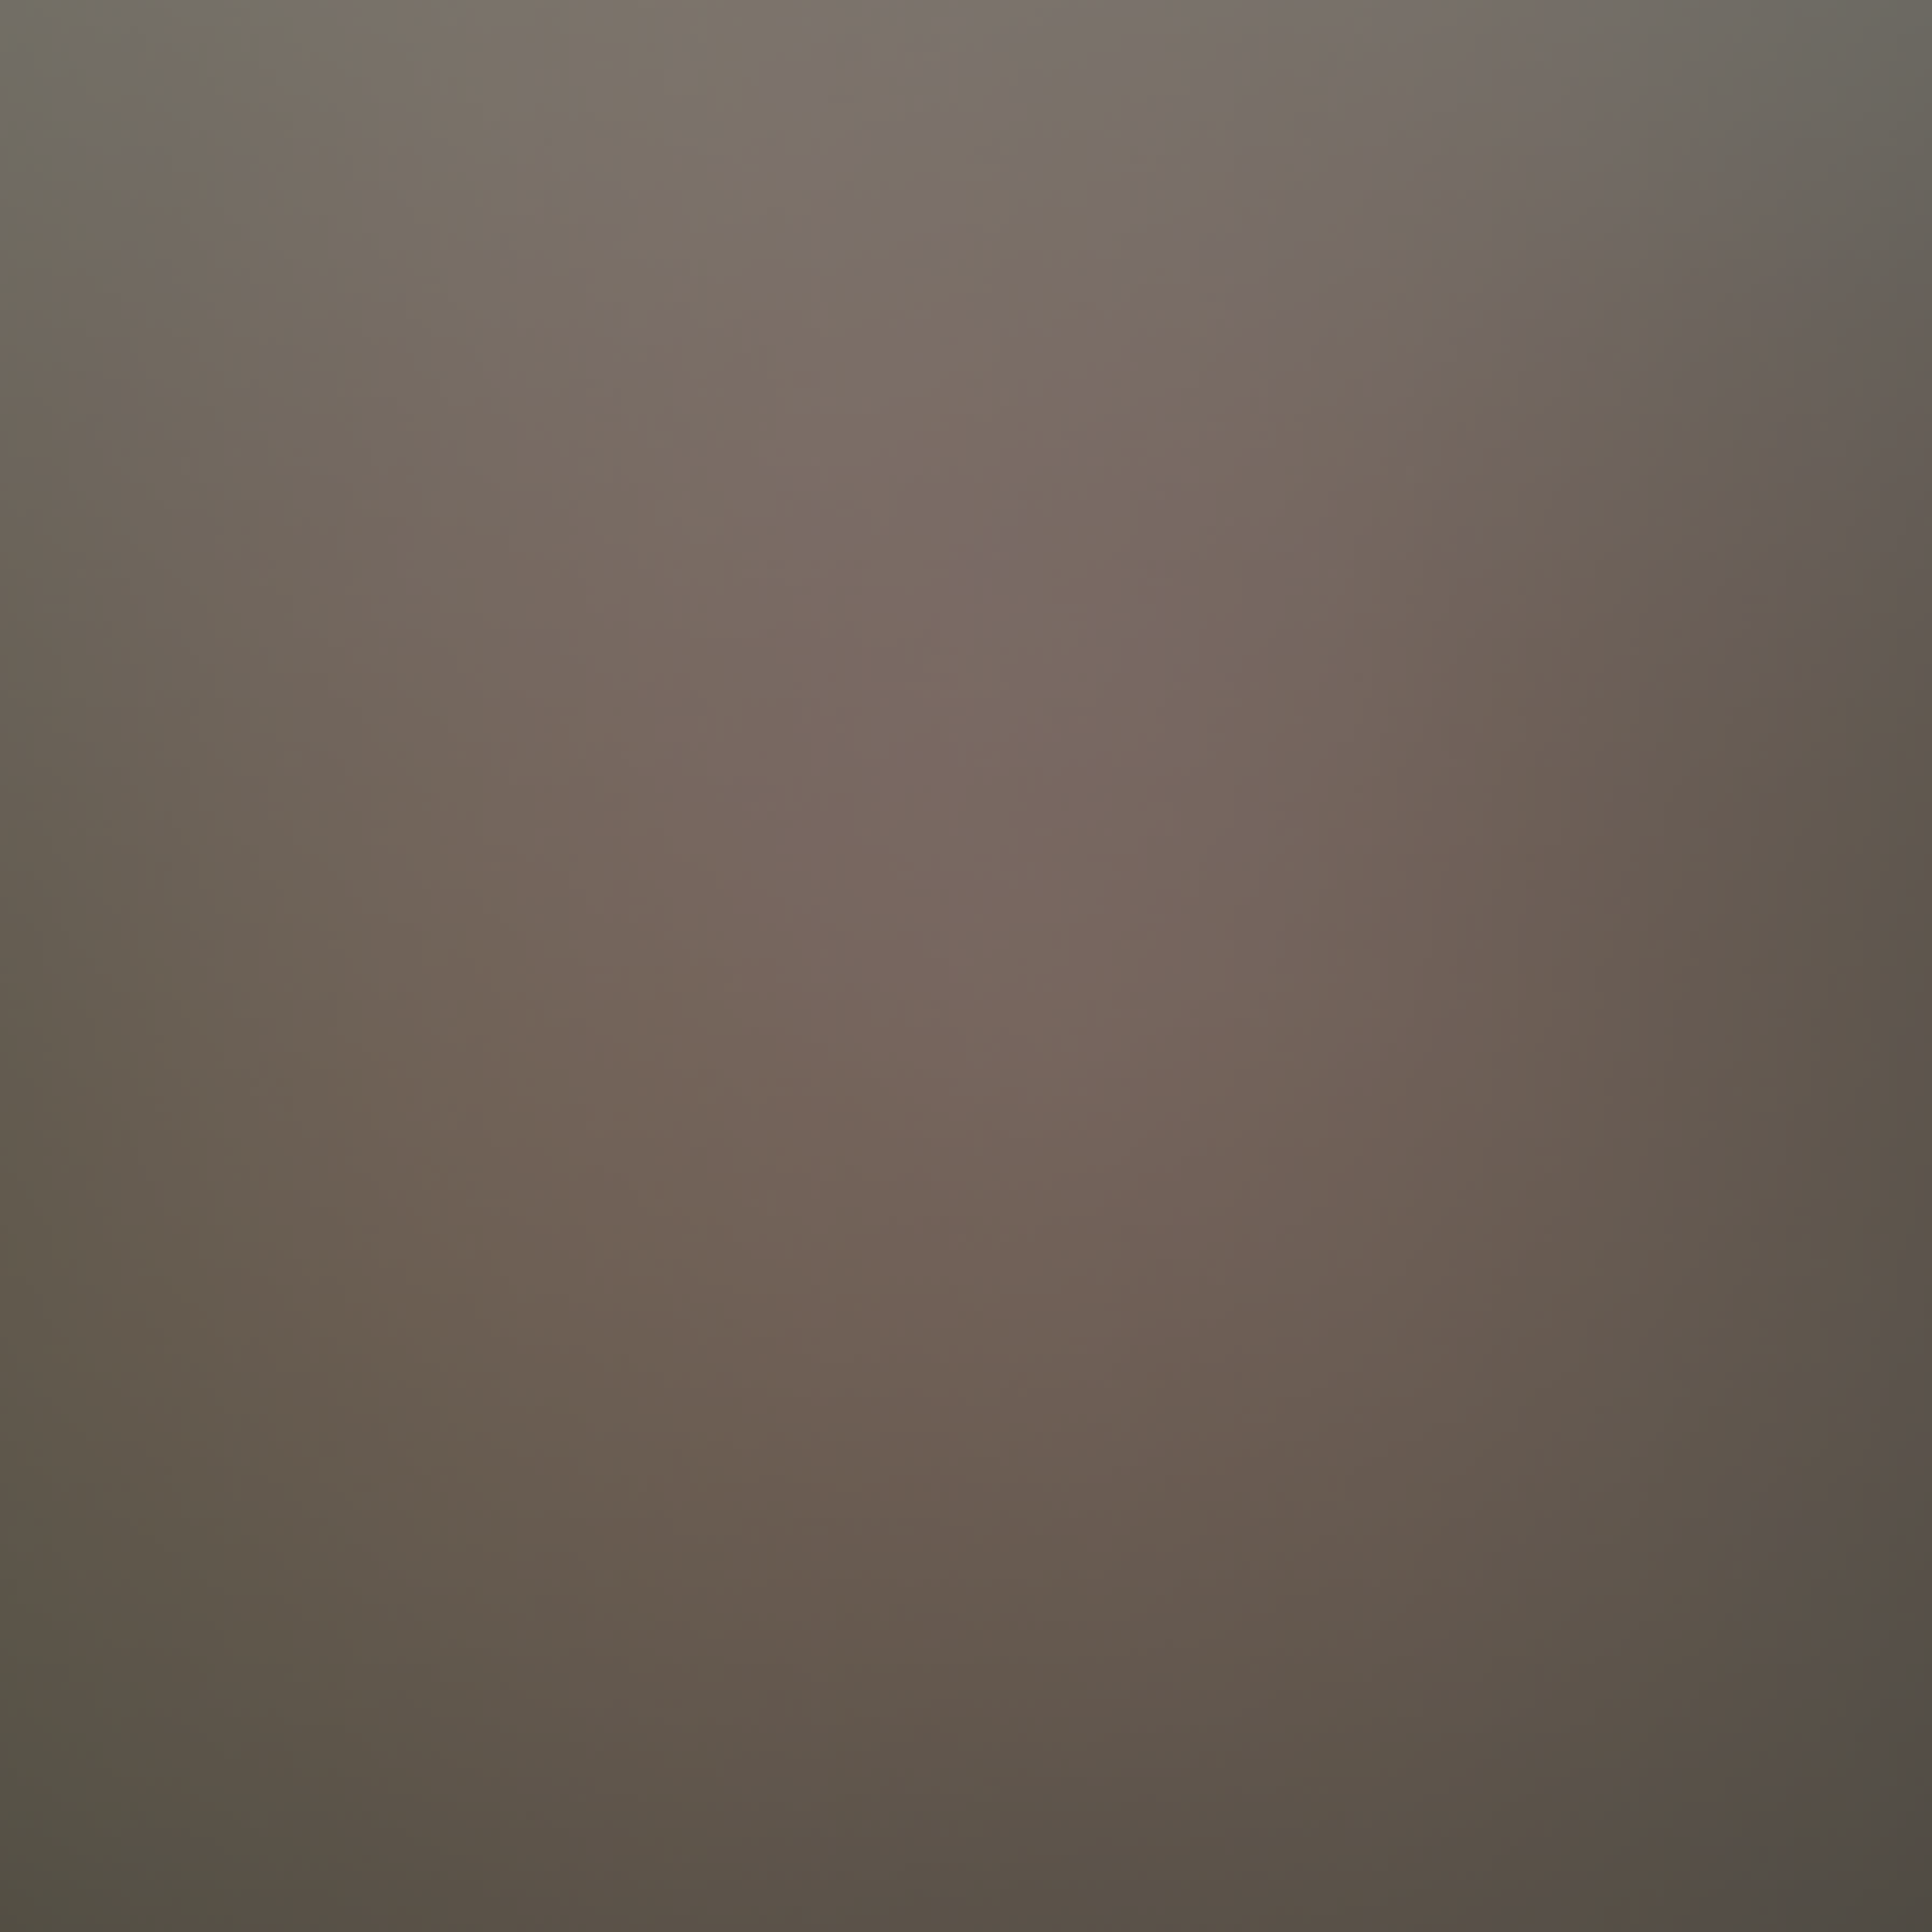

In [6]:
if TRAIN_MEAN_IMG_FILE.exists():
    train_mean_img = torch.load(TRAIN_MEAN_IMG_FILE)
else:
    train_dataset = my_data.datasets['train']
    train_mean_img = get_data_mean_img(train_dataset.data)
    torch.save(train_mean_img, TRAIN_MEAN_IMG_FILE)

from multimodal.attention_maps import n_inv
plt.imshow(n_inv(train_mean_img).permute((1, 2, 0)).numpy())
plt.axis('off')
output_fig('Train Mean Image')

train_mean_img = train_mean_img.to(device)
zero_img = torch.zeros(3, IMAGE_H, IMAGE_W, dtype=torch.float, device=device)


def prepend_image_placeholder_for_batch(model, x):
    x = x.to(device=device)
    x = x.unsqueeze(0)
    if isinstance(model, MultiModalLitModel) and (
            model.language_model.text_encoder.captioning or
            model.language_model.text_encoder.has_attention):
        image_features, image_feature_map = model.model.encode_image(x)
        image_features = image_features.squeeze(0)
        image_feature_map = image_feature_map.squeeze(0)
    else:
        image_features, image_feature_map = None, None

    def _fn(batch):
        y, y_len, raw_y = batch
        batch_size = len(y)
        batch = {
            'y': y,
            'y_len': y_len,
        }
        if image_features is not None:
            batch['image_features'] = image_features.expand(*([batch_size] + [-1] * image_features.dim()))
        if image_feature_map is not None:
            batch['image_feature_map'] = image_feature_map.expand(*([batch_size] + [-1] * image_feature_map.dim()))
        return batch

    return _fn

In [7]:
loss_dfs = {
    data_name: pd.DataFrame(np.zeros((len(dataset), 0)))
    for data_name, dataset in datasets.items()
}


my_model_format = ({'saycam': 'SAYCam-S', 'childes': 'CHILDES-Sarah'}[dataset_name] + ' {}').format

my_groups = {my_model_format(name): list(map(my_model_format, group)) for name, group in groups.items()}

for model_name, model in ori_models.items():
    print(f'running {model_name} ...')
    my_model_name = my_model_format(model_name)
    for data_name, dataset in datasets.items():
        if not dataset:
            continue
        dataloader = DataLoader(
            dataset,
            collate_fn=collate_fn,
            shuffle=False,
            batch_size=my_batch_size,
            drop_last=False,
        )
        batches = map(prepend_image_placeholder_for_batch(model, train_mean_img), dataloader)
        losses = get_model_losses_on_batches(model, batches)
        losses = losses.cpu().numpy()
        loss_dfs[data_name][my_model_name] = losses

for probing_results_dir in Path('/misc/vlgscratch4/LakeGroup/wentao/BabyBERTa/probing_results/babyberta').glob('*'):
    model_name = probing_results_dir.name
    if model_name not in ['BabyBERTa_AO-CHILDES', 'BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1'][:1]:
        continue
    name_, _, dataset_ = model_name.partition('_')
    model_name = dataset_ + ' ' + 'Transformer'
    my_groups[model_name] = [model_name]
    for file in probing_results_dir.glob('*'):
        paradigm_name = file.stem
        data_name = get_data_name_from_paradigm_name(paradigm_name)
        sentences, losses = zip(*read_sentences_and_losses(file))
        loss_dfs[data_name][model_name] = losses

running LSTM 0 ...
running LSTM 1 ...
running LSTM 2 ...
running Captioning LSTM 0 ...
running Captioning LSTM 1 ...
running Captioning LSTM 2 ...
running CBOW 0 ...
running CBOW 1 ...
running CBOW 2 ...
running 1-gram ...
running 2-gram ...


In [8]:
def get_common_substr_len(strs, index_fn=lambda l: l):
    l = 0
    l_last_space = -1
    while True:
        try:
            c = None
            for s in strs:
                cur_c = s[index_fn(l)]
                if c is None:
                    c = cur_c
                assert c == cur_c
        except (IndexError, AssertionError):
            break
        if c == ' ':
            l_last_space = l
        l += 1
    return l_last_space + 1


def get_sentence_pair_str(sentence_pair):
    strs = list(map(str, sentence_pair))
    prefix_len = get_common_substr_len(strs)
    suffix_len = get_common_substr_len(strs, lambda l: -l-1)
    return strs[0][:prefix_len] + '(' + '/'.join(reversed([s[prefix_len:-suffix_len] for s in strs])) + ')' + strs[0][-suffix_len:]


def get_sentence_pair_example(sentence_pairs, sample_n=0):
    if sample_n:
        samples = sentence_pairs.sample(n=sample_n)
        for sample in samples:
            print(get_sentence_pair_str(sample))
    return min(map(get_sentence_pair_str, sentence_pairs), key=len)


data_examples = {}
for data_name, sentences in zorro_data.items():
    print(f'{data_name}:')
    sentence_pairs = pd.Series(paired(sentences))[filter_masks[data_name]]
    if len(sentence_pairs):
        example_str = get_sentence_pair_example(sentence_pairs)

        # remove the space before the last punctuation
        if example_str[-2] == ' ':
            example_str = example_str[:-2] + example_str[-1:]

        data_examples[data_name] = example_str

phenomenon_examples = defaultdict(list)
for data_name, example_str in data_examples.items():
    phenomenon_examples[data_name[0]].append(example_str)
phenomenon_examples = {phenomenon: min(examples, key=len) for phenomenon, examples in phenomenon_examples.items()}

('determiner-noun agreement', 'across 1 adjective'):
('determiner-noun agreement', 'between neighbors'):
('subject-verb agreement', 'across prepositional phrase'):
('subject-verb agreement', 'across relative clause'):
('subject-verb agreement', 'in question with aux'):
('subject-verb agreement', 'in simple question'):
('anaphor agreement', 'pronoun gender'):
('argument structure', 'dropped argument'):
('argument structure', 'swapped arguments'):
('argument structure', 'transitive'):
('binding', 'principle a'):
('case', 'subjective pronoun'):
('ellipsis', 'n bar'):
('filler-gap', 'wh question object'):
('filler-gap', 'wh question subject'):
('irregular', 'verb'):
('island-effects', 'adjunct island'):
('island-effects', 'coordinate structure constraint'):
('local attractor', 'in question with aux'):
('npi licensing', 'matrix question'):
('npi licensing', 'only npi licensor'):
('quantifiers', 'existential there'):
('quantifiers', 'superlative'):


SAYCam-S LSTM  SAYCam-S Captioning LSTM  SAYCam-S CBOW  \
phenomenon                paradigm                                                                              
argument structure        dropped argument                  0.780392                  0.734641       0.674510   
                          swapped arguments                 0.972441                  0.933071       0.996063   
                          transitive                        0.594982                  0.597372       0.589008   
case                      subjective pronoun                0.916031                  0.815522       0.988550   
determiner-noun agreement across 1 adjective                0.663510                  0.660354       0.408460   
                          between neighbors                 0.743939                  0.724242       0.819697   
local attractor           in question with aux              0.798969                  0.785223       0.622852   
npi licensing             matrix question                   0.531153                  0.591900       0.436137   
                          only npi licensor                 0.957187                  0.908257       0.795107   
quantifiers               existential there                 0.965217                  0.985507       0.805797   
                          superlative                       0.472222                  0.791667       0.775000   
subject-verb agreement    across prepositional phrase       0.536008                  0.525720       0.500000   
                          across relative clause            0.556548                  0.538690       0.500000   
                          in question with aux              0.576812                  0.572464       0.478261   
                          in simple question                0.633648                  0.631027       0.415618   

                                                       SAYCam-S unigram  SAYCam-S bigram  AO-CHILDES Transformer  
phenomenon                paradigm                                                                                
argument structure        dropped argument                     0.431373         0.686275                0.694118  
                          swapped arguments                    0.157480         0.980315                0.992126  
                          transitive                           0.433692         0.555556                0.670251  
case                      subjective pronoun                   0.019084         1.000000                0.931298  
determiner-noun agreement across 1 adjective                   0.500000         0.500000                0.975379  
                          between neighbors                    0.500000         0.693182                0.995455  
local attractor           in question with aux                 0.868557         0.860825                0.963918  
npi licensing             matrix question                      0.028037         0.644860                0.719626  
                          only npi licensor                    1.000000         0.834862                0.559633  
quantifiers               existential there                    0.886957         0.956522                1.000000  
                          superlative                          1.000000         0.633333                0.966667  
subject-verb agreement    across prepositional phrase          0.500000         0.469136                0.777778  
                          across relative clause               0.500000         0.500000                0.832589  
                          in question with aux                 0.500000         0.478261                0.908696  
                          in simple question                   0.500000         0.490566                0.988994

,SAYCam-S LSTM,SAYCam-S Captioning LSTM,SAYCam-S CBOW,SAYCam-S unigram,SAYCam-S bigram,AO-CHILDES Transformer
phenomenon,,,,,,
argument structure,0.782605,0.755028,0.753194,0.340848,0.740715,0.785498
case,0.916031,0.815522,0.988550,0.019084,1.000000,0.931298
determiner-noun agreement,0.703725,0.692298,0.614078,0.500000,0.596591,0.985417
local attractor,0.798969,0.785223,0.622852,0.868557,0.860825,0.963918
npi licensing,0.744170,0.750079,0.615622,0.514019,0.739861,0.639630
quantifiers,0.718720,0.888587,0.790399,0.943478,0.794928,0.983333
subject-verb agreement,0.575754,0.566975,0.473470,0.500000,0.484491,0.877014


SAYCam-S LSTM               0.713271
SAYCam-S Captioning LSTM    0.719710
SAYCam-S CBOW               0.653671
SAYCam-S unigram            0.521679
SAYCam-S bigram             0.685579
AO-CHILDES Transformer      0.865102
dtype: float64

,phenomenon,paradigm,idx,model,accuracy,phenomenon paradigm
0,determiner-noun agreement,across 1 adjective,0,SAYCam-S LSTM,0.000000,determiner-noun agreement\nacross 1 adjective
1,determiner-noun agreement,across 1 adjective,1,SAYCam-S LSTM,0.333333,determiner-noun agreement\nacross 1 adjective
2,determiner-noun agreement,across 1 adjective,2,SAYCam-S LSTM,0.666667,determiner-noun agreement\nacross 1 adjective
3,determiner-noun agreement,across 1 adjective,3,SAYCam-S LSTM,0.666667,determiner-noun agreement\nacross 1 adjective
4,determiner-noun agreement,across 1 adjective,4,SAYCam-S LSTM,0.333333,determiner-noun agreement\nacross 1 adjective
...,...,...,...,...,...,...
27607,quantifiers,superlative,1951,AO-CHILDES Transformer,1.000000,quantifiers\nsuperlative
27608,quantifiers,superlative,1960,AO-CHILDES Transformer,1.000000,quantifiers\nsuperlative
27609,quantifiers,superlative,1972,AO-CHILDES Transformer,1.000000,quantifiers\nsuperlative
27610,quantifiers,superlative,1974,AO-CHILDES Transformer,1.000000,quantifiers\nsuperlative


/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

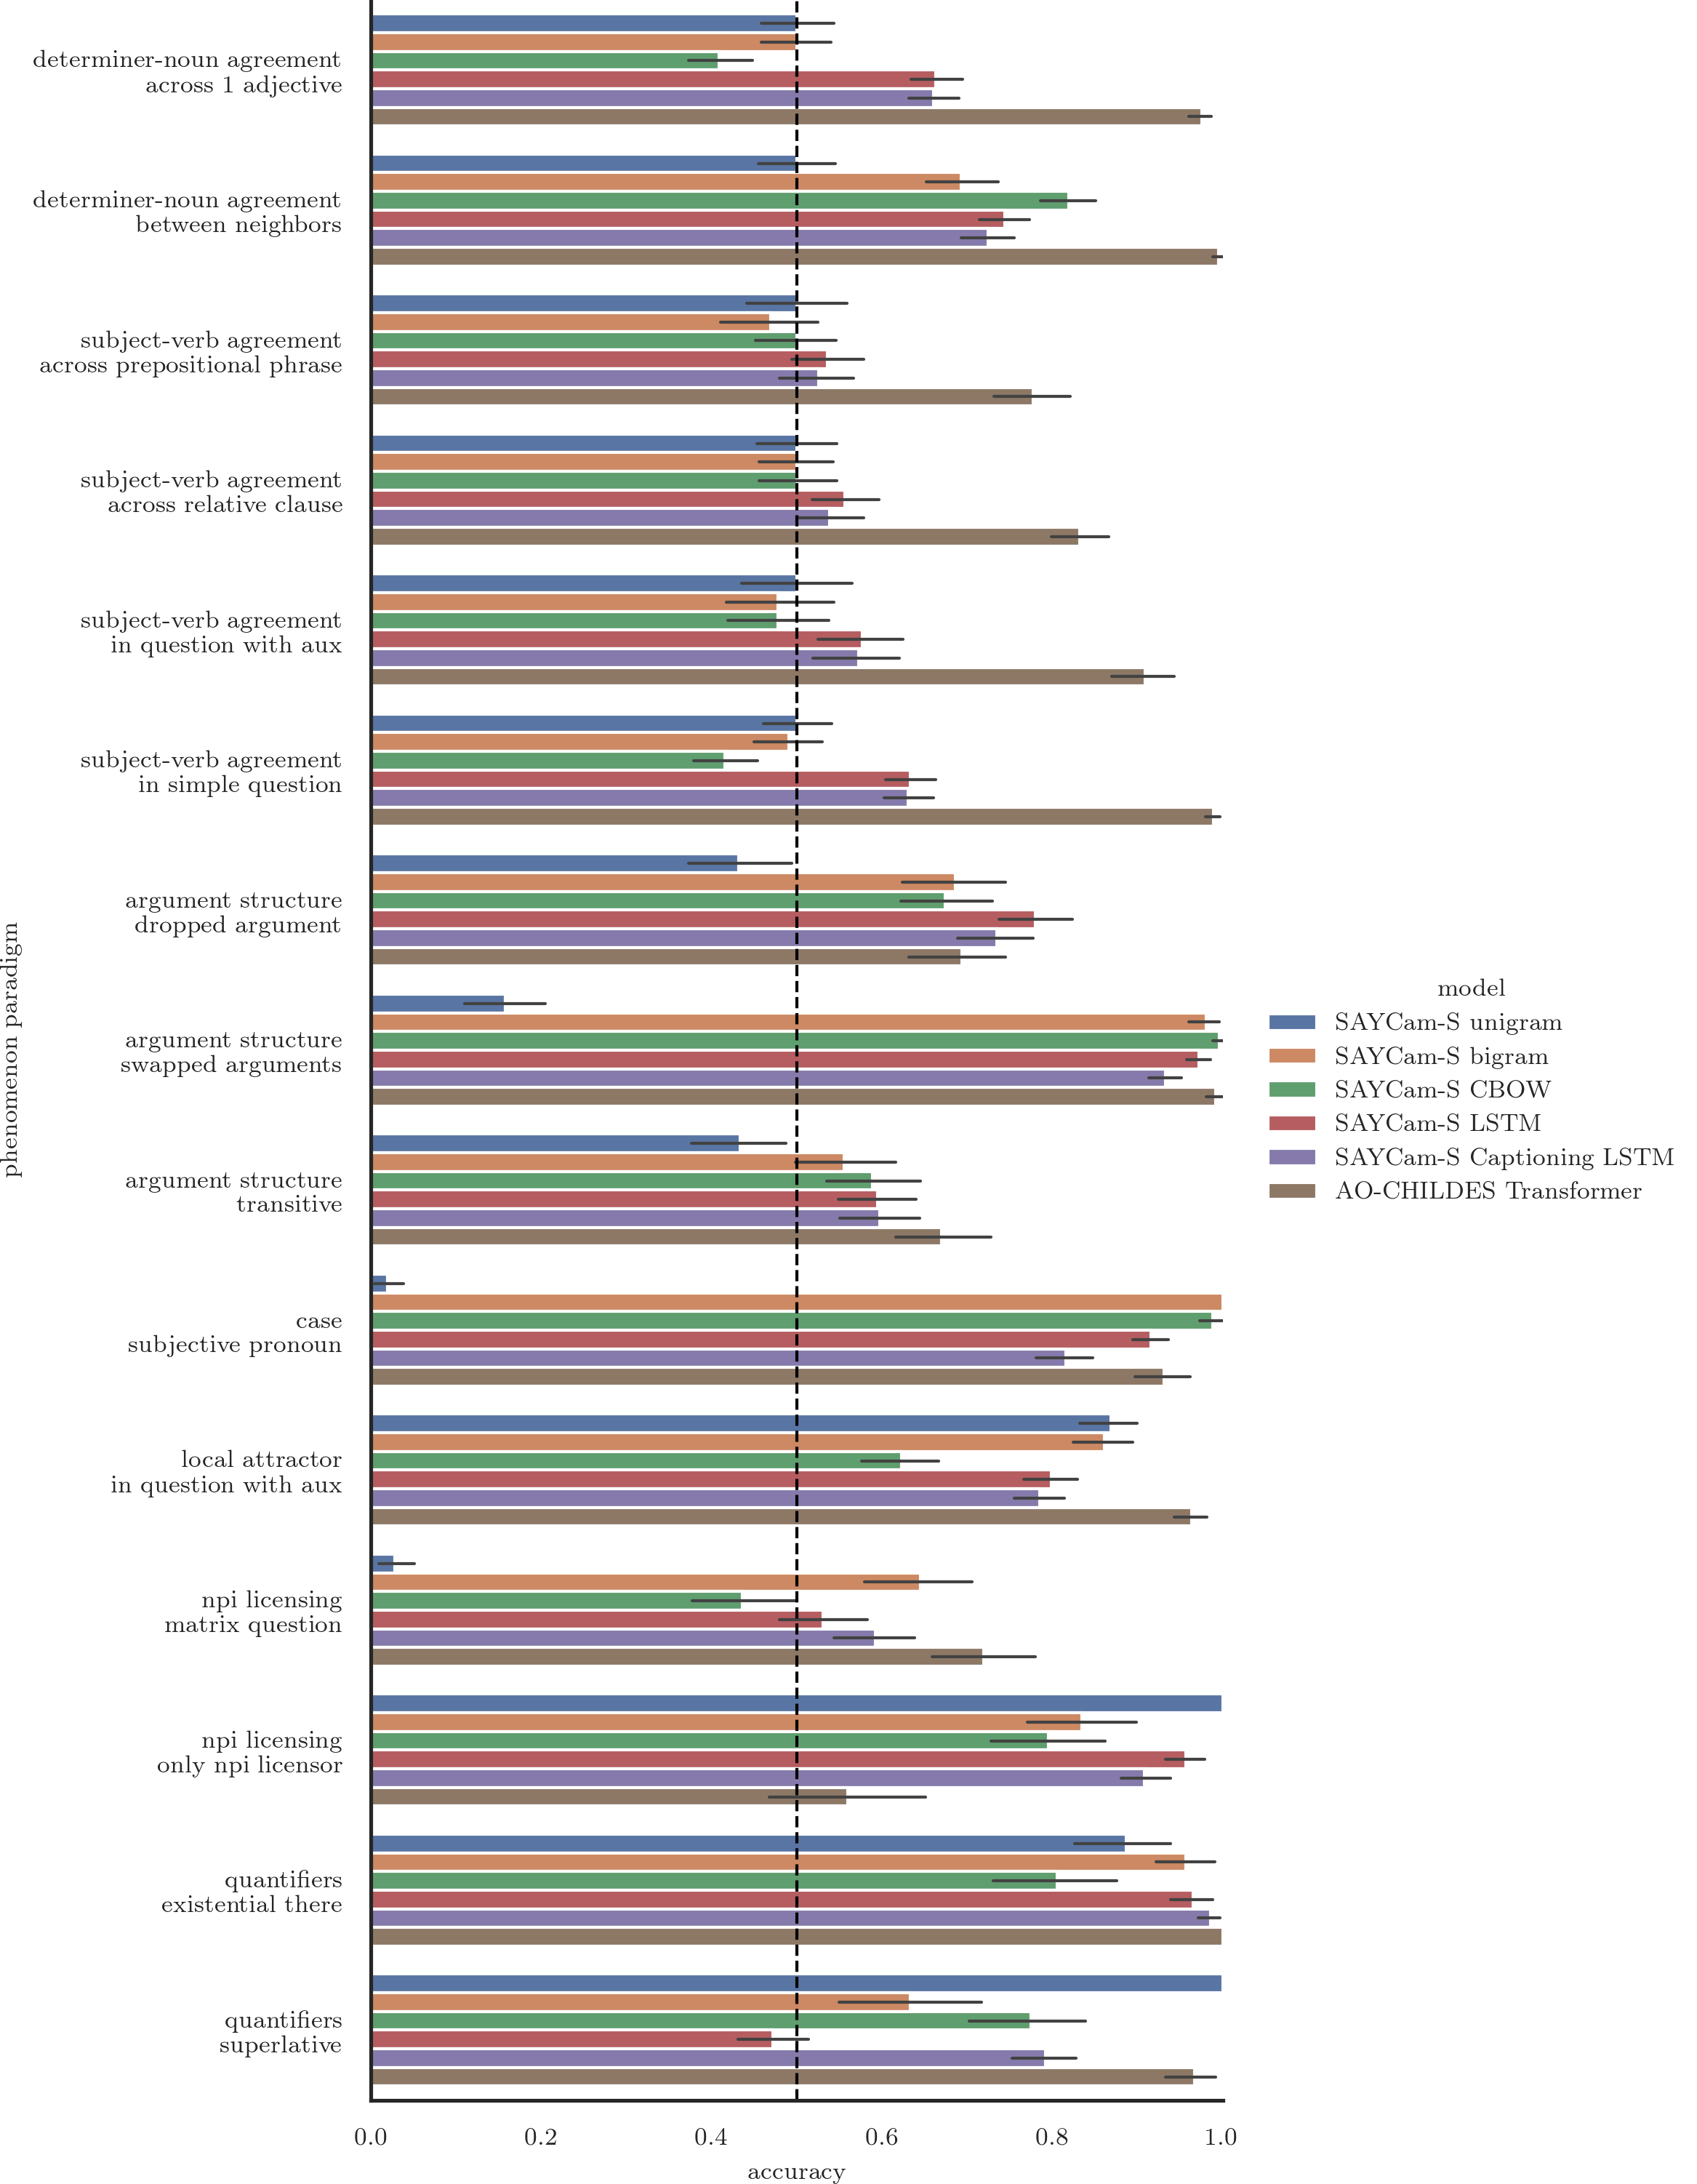

/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

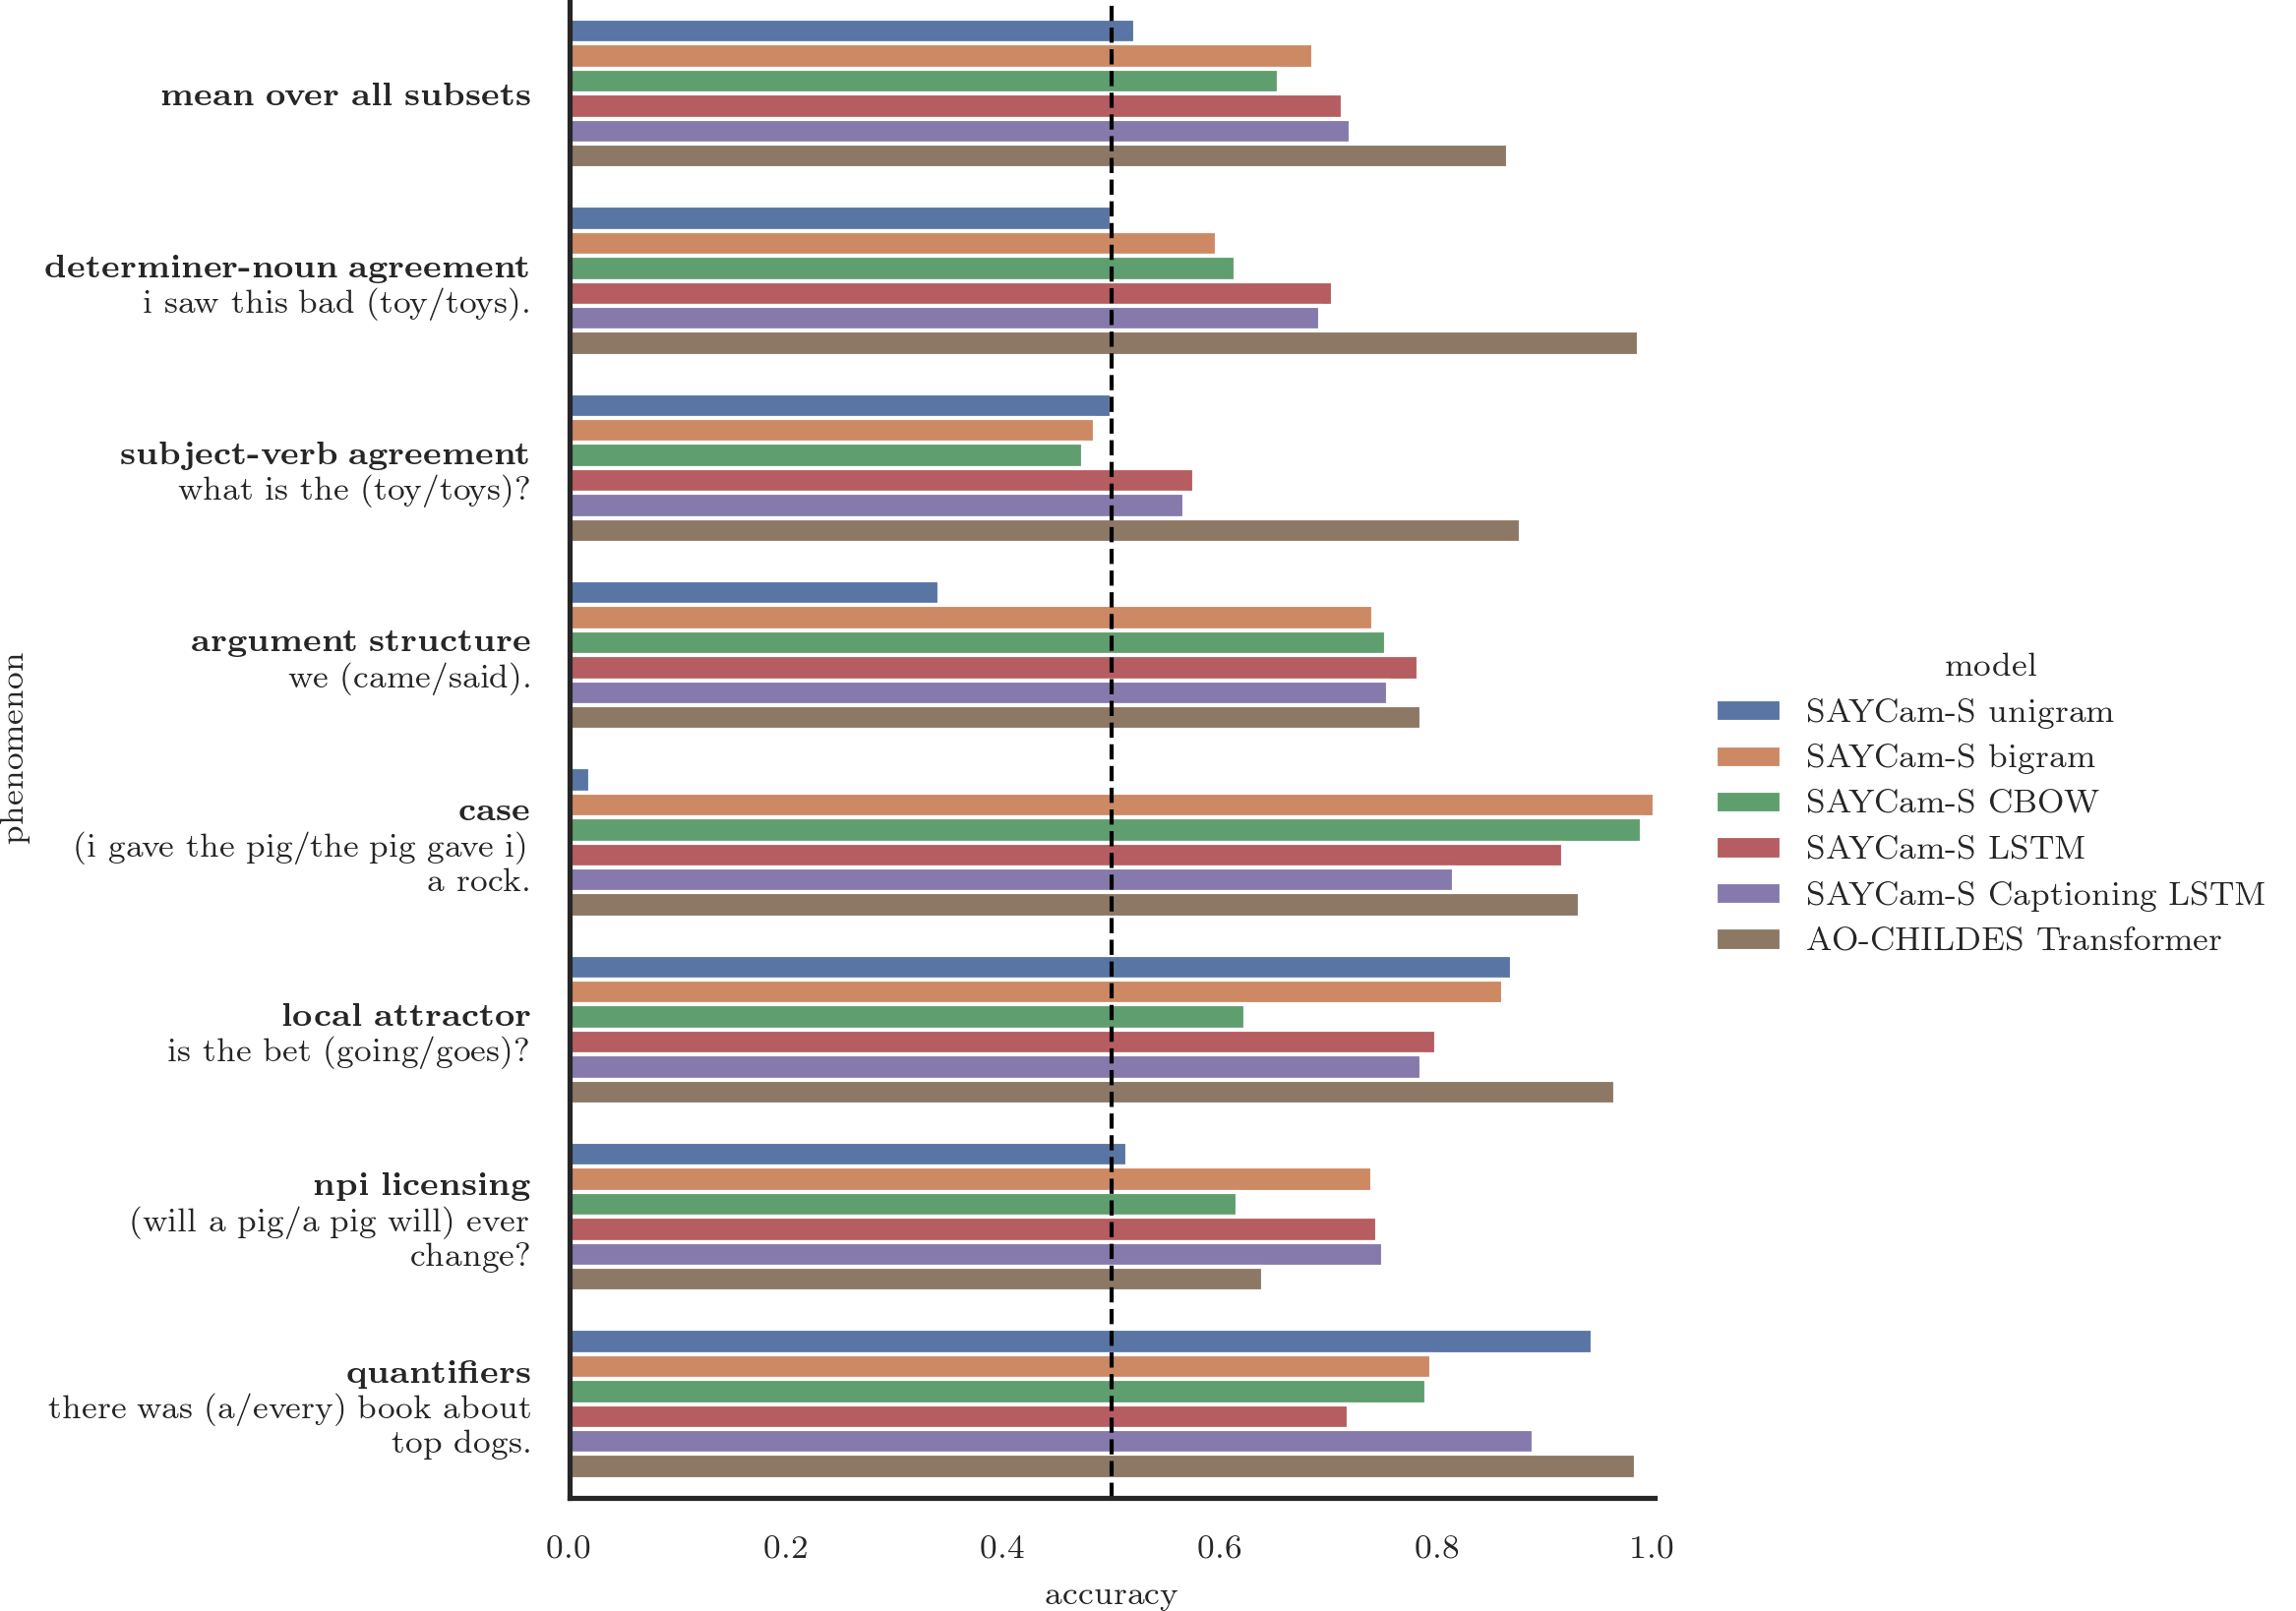

/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/misc/vlgscratch4/LakeGroup/wentao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

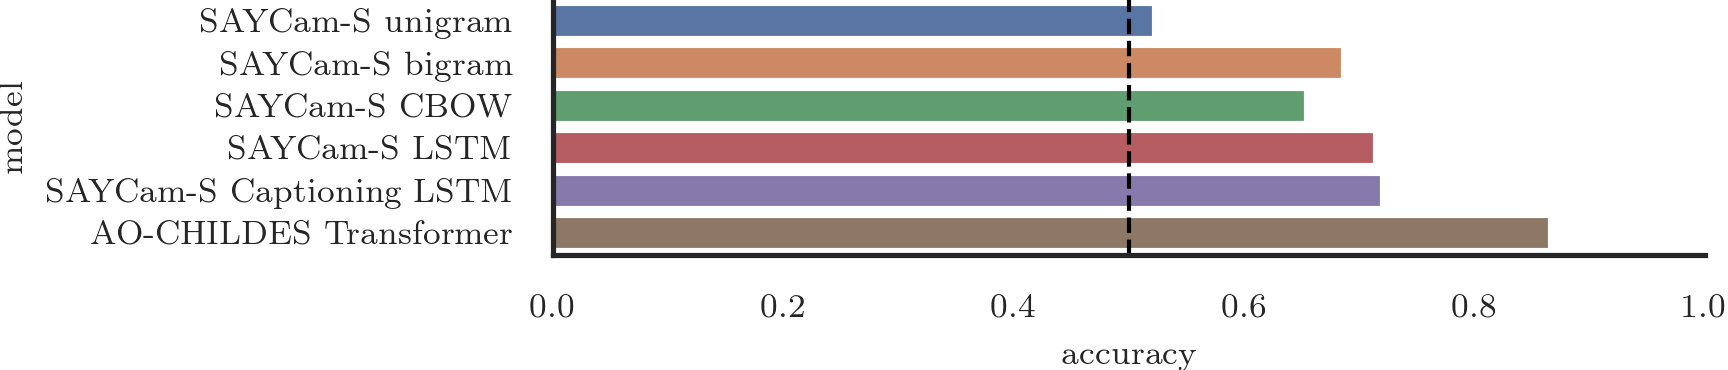

comparing ('argument structure', 'dropped argument') (255 / 2000.0 = 12.75%):


SAYCam-S LSTM               0.780392
SAYCam-S Captioning LSTM    0.734641
SAYCam-S CBOW               0.674510
SAYCam-S unigram            0.431373
SAYCam-S bigram             0.686275
AO-CHILDES Transformer      0.694118
Name: (argument structure, dropped argument), dtype: float64

the boat looks at some .
the boat looks at me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 2, dtype: bool

the boat saw me by .
the boat saw me there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 8, dtype: bool

the boat looks at my .
the boat looks at him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 40, dtype: bool

some doctor saw her by .
some doctor saw her there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 60, dtype: bool

a boat told you about a .
a boat told you about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 62, dtype: bool

one pig changed a .
one pig changed him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 72, dtype: bool

one boat asked them about .
one boat asked about them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 75, dtype: bool

my pig asked me about .
my pig asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 85, dtype: bool

his boat looks at some .
his boat looks at you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 93, dtype: bool

some boat told you about the .
some boat told you about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 106, dtype: bool

some boat works when .
some boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 123, dtype: bool

a doctor works and .
a doctor works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 141, dtype: bool

my boat wanted to .
my boat wanted me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 157, dtype: bool

my boat works but .
my boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 166, dtype: bool

the pig changed some .
the pig changed me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 181, dtype: bool

his doctor changed one .
his doctor changed me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 194, dtype: bool

one doctor wanted to .
one doctor wanted them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 196, dtype: bool

his boat works but .
his boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 201, dtype: bool

the pig looks at some .
the pig looks at him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 203, dtype: bool

a doctor looks at some .
a doctor looks at you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 235, dtype: bool

a boat works but .
a boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 302, dtype: bool

the doctor plays with my .
the doctor plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 322, dtype: bool

the doctor works when .
the doctor works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 324, dtype: bool

the boat asked you about .
the boat asked about you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 384, dtype: bool

his boat looks at some .
his boat looks at him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 400, dtype: bool

a doctor saw him by .
a doctor saw him there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 454, dtype: bool

my boat plays with his .
my boat plays with her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 491, dtype: bool

one boat plays with his .
one boat plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 514, dtype: bool

some doctor asked her about .
some doctor asked about her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 516, dtype: bool

some doctor changed some .
some doctor changed me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 535, dtype: bool

a pig changed my .
a pig changed them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 544, dtype: bool

some boat plays with my .
some boat plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 548, dtype: bool

his boat told him about a .
his boat told him about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 633, dtype: bool

my boat asked them about .
my boat asked about them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 641, dtype: bool

one pig plays with some .
one pig plays with me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 648, dtype: bool

some boat saw him by .
some boat saw him there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 649, dtype: bool

one doctor changed a .
one doctor changed him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 689, dtype: bool

the boat works with .
the boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 692, dtype: bool

my pig plays with some .
my pig plays with me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 702, dtype: bool

one doctor told you about the .
one doctor told you about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 703, dtype: bool

a boat saw me by .
a boat saw me there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 719, dtype: bool

my pig looks at a .
my pig looks at them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 723, dtype: bool

some doctor saw him by .
some doctor saw him there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 726, dtype: bool

my doctor wanted to .
my doctor wanted me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 736, dtype: bool

my pig works when .
my pig works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 740, dtype: bool

my boat saw me by .
my boat saw me there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 756, dtype: bool

a boat looks at one .
a boat looks at me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 764, dtype: bool

his pig looks at some .
his pig looks at you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 785, dtype: bool

a boat changed one .
a boat changed them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 789, dtype: bool

one doctor plays with some .
one doctor plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 804, dtype: bool

some doctor looks at a .
some doctor looks at her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 809, dtype: bool

one pig plays with my .
one pig plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 830, dtype: bool

a boat plays with his .
a boat plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 850, dtype: bool

some doctor asked me about .
some doctor asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 897, dtype: bool

some doctor works when .
some doctor works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 921, dtype: bool

one boat asked me about .
one boat asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 930, dtype: bool

his pig works when .
his pig works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 933, dtype: bool

his pig looks at some .
his pig looks at him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 940, dtype: bool

the boat changed his .
the boat changed her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 949, dtype: bool

his pig saw me by .
his pig saw me there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 977, dtype: bool

a doctor looks at one .
a doctor looks at me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 990, dtype: bool

a doctor asked them about .
a doctor asked about them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 992, dtype: bool

his boat asked him about .
his boat asked about him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1001, dtype: bool

some boat plays with his .
some boat plays with her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1005, dtype: bool

one boat looks at one .
one boat looks at you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1058, dtype: bool

a boat plays with his .
a boat plays with her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1064, dtype: bool

one pig asked you about .
one pig asked about you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1085, dtype: bool

some boat saw her by .
some boat saw her there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1120, dtype: bool

the doctor told him about a .
the doctor told him about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1143, dtype: bool

some doctor told them about a .
some doctor told them about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1209, dtype: bool

my boat looks at one .
my boat looks at me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1245, dtype: bool

his doctor asked them about .
his doctor asked about them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1303, dtype: bool

a boat saw her by .
a boat saw her there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1325, dtype: bool

a pig plays with the .
a pig plays with me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1351, dtype: bool

his boat looks at one .
his boat looks at them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1353, dtype: bool

some boat looks at a .
some boat looks at me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1356, dtype: bool

my pig plays with my .
my pig plays with them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1381, dtype: bool

my boat changed some .
my boat changed me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1384, dtype: bool

a boat asked her about .
a boat asked about her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1411, dtype: bool

my pig asked him about .
my pig asked about him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1454, dtype: bool

some boat wanted to .
some boat wanted me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1460, dtype: bool

the boat asked me about .
the boat asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1468, dtype: bool

his boat changed a .
his boat changed her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1478, dtype: bool

some boat looks at his .
some boat looks at him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1487, dtype: bool

my pig changed some .
my pig changed them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1496, dtype: bool

some pig looks at a .
some pig looks at her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1500, dtype: bool

my boat plays with some .
my boat plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1526, dtype: bool

his boat changed a .
his boat changed them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1536, dtype: bool

one boat changed the .
one boat changed them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1540, dtype: bool

my boat looks at some .
my boat looks at them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1545, dtype: bool

one doctor asked me about .
one doctor asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1557, dtype: bool

an boat asked you about .
an boat asked about you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1560, dtype: bool

the pig asked him about .
the pig asked about him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1563, dtype: bool

my pig changed his .
my pig changed him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1566, dtype: bool

my boat asked me about .
my boat asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1587, dtype: bool

a doctor asked her about .
a doctor asked about her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1600, dtype: bool

one pig told her about the .
one pig told her about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1605, dtype: bool

his boat told me about the .
his boat told me about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1615, dtype: bool

some pig asked me about .
some pig asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1616, dtype: bool

the pig saw me by .
the pig saw me there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1620, dtype: bool

a pig told you about the .
a pig told you about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1659, dtype: bool

one pig asked her about .
one pig asked about her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1662, dtype: bool

my boat told me about a .
my boat told me about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1663, dtype: bool

some boat looks at the .
some boat looks at them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1687, dtype: bool

the doctor plays with the .
the doctor plays with you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1699, dtype: bool

a doctor saw her by .
a doctor saw her there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1704, dtype: bool

the doctor changed a .
the doctor changed me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1709, dtype: bool

one doctor looks at a .
one doctor looks at them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1721, dtype: bool

the doctor looks at some .
the doctor looks at you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1722, dtype: bool

one doctor asked you about .
one doctor asked about you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1726, dtype: bool

a doctor asked him about .
a doctor asked about him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1734, dtype: bool

my doctor saw her by .
my doctor saw her there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1753, dtype: bool

the doctor asked me about .
the doctor asked about me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1760, dtype: bool

the pig changed a .
the pig changed her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1762, dtype: bool

my doctor asked her about .
my doctor asked about her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1774, dtype: bool

his doctor asked her about .
his doctor asked about her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1785, dtype: bool

a doctor told me about the .
a doctor told me about that .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1789, dtype: bool

my doctor looks at some .
my doctor looks at me .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1797, dtype: bool

some pig saw me by .
some pig saw me there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1807, dtype: bool

an boat works and .
an boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1819, dtype: bool

an boat plays with the .
an boat plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1837, dtype: bool

one boat saw him by .
one boat saw him there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1846, dtype: bool

the pig changed a .
the pig changed them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1854, dtype: bool

some doctor changed a .
some doctor changed her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1865, dtype: bool

a doctor looks at his .
a doctor looks at him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1875, dtype: bool

his doctor plays with the .
his doctor plays with them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1917, dtype: bool

his doctor looks at one .
his doctor looks at her .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1925, dtype: bool

some doctor plays with his .
some doctor plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1942, dtype: bool

the boat plays with one .
the boat plays with him .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1943, dtype: bool

one boat works and .
one boat works well .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1946, dtype: bool

a boat asked you about .
a boat asked about you .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1983, dtype: bool

the doctor plays with a .
the doctor plays with them .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1988, dtype: bool

comparing ('determiner-noun agreement', 'across 1 adjective') (528 / 2000.0 = 26.40%):


SAYCam-S LSTM               0.663510
SAYCam-S Captioning LSTM    0.660354
SAYCam-S CBOW               0.408460
SAYCam-S unigram            0.500000
SAYCam-S bigram             0.500000
AO-CHILDES Transformer      0.975379
Name: (determiner-noun agreement, across 1 adjective), dtype: float64

this purple things went there .
this purple thing went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1, dtype: bool

this purple things did not happen .
this purple thing did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 2, dtype: bool

i saw this purple things .
i saw this purple thing .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 3, dtype: bool

that purple things went there .
that purple thing went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 5, dtype: bool

that purple things did not happen .
that purple thing did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 6, dtype: bool

i saw that purple things .
i saw that purple thing .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 7, dtype: bool

look at these purple thing .
look at these purple things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 8, dtype: bool

i saw these purple thing .
i saw these purple things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 11, dtype: bool

look at those purple thing .
look at those purple things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 12, dtype: bool

i saw those purple thing .
i saw those purple things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 15, dtype: bool

this soft arms went there .
this soft arm went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 17, dtype: bool

this soft arms did not happen .
this soft arm did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 18, dtype: bool

i saw this soft arms .
i saw this soft arm .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 19, dtype: bool

that soft arms went there .
that soft arm went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 21, dtype: bool

that soft arms did not happen .
that soft arm did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 22, dtype: bool

i saw that soft arms .
i saw that soft arm .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 23, dtype: bool

look at these soft arm .
look at these soft arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 24, dtype: bool

look at those soft arm .
look at those soft arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 28, dtype: bool

this full arms went there .
this full arm went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 113, dtype: bool

this full arms did not happen .
this full arm did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 114, dtype: bool

i saw this full arms .
i saw this full arm .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 115, dtype: bool

that full arms did not happen .
that full arm did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 118, dtype: bool

i saw that full arms .
i saw that full arm .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 119, dtype: bool

look at these full arm .
look at these full arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 120, dtype: bool

look at those full arm .
look at those full arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 124, dtype: bool

those full arm went there .
those full arms went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 125, dtype: bool

those full arm did not happen .
those full arms did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 126, dtype: bool

look at this nice toys .
look at this nice toy .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 144, dtype: bool

this nice toys went there .
this nice toy went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 145, dtype: bool

this nice toys did not happen .
this nice toy did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 146, dtype: bool

i saw this nice toys .
i saw this nice toy .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 147, dtype: bool

look at that nice toys .
look at that nice toy .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 148, dtype: bool

that nice toys went there .
that nice toy went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 149, dtype: bool

that nice toys did not happen .
that nice toy did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 150, dtype: bool

i saw that nice toys .
i saw that nice toy .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 151, dtype: bool

look at these nice toy .
look at these nice toys .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 152, dtype: bool

i saw these nice toy .
i saw these nice toys .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 155, dtype: bool

look at this extra days .
look at this extra day .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 192, dtype: bool

this extra days went there .
this extra day went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 193, dtype: bool

i saw this extra days .
i saw this extra day .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 195, dtype: bool

look at that extra days .
look at that extra day .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 196, dtype: bool

that extra days went there .
that extra day went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 197, dtype: bool

i saw that extra days .
i saw that extra day .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 199, dtype: bool

look at these extra day .
look at these extra days .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 200, dtype: bool

i saw these extra day .
i saw these extra days .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 203, dtype: bool

look at those extra day .
look at those extra days .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 204, dtype: bool

i saw those extra day .
i saw those extra days .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 207, dtype: bool

that good fingers did not happen .
that good finger did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 310, dtype: bool

look at this hard minutes .
look at this hard minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 320, dtype: bool

this hard minutes went there .
this hard minute went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 321, dtype: bool

this hard minutes did not happen .
this hard minute did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 322, dtype: bool

i saw this hard minutes .
i saw this hard minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 323, dtype: bool

look at that hard minutes .
look at that hard minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 324, dtype: bool

that hard minutes went there .
that hard minute went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 325, dtype: bool

that hard minutes did not happen .
that hard minute did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 326, dtype: bool

i saw that hard minutes .
i saw that hard minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 327, dtype: bool

these hard minute went there .
these hard minutes went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 329, dtype: bool

those hard minute went there .
those hard minutes went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 333, dtype: bool

look at this early feet .
look at this early foot .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 368, dtype: bool

this early feet did not happen .
this early foot did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 370, dtype: bool

i saw this early feet .
i saw this early foot .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 371, dtype: bool

look at that early feet .
look at that early foot .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 372, dtype: bool

that early feet did not happen .
that early foot did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 374, dtype: bool

i saw that early feet .
i saw that early foot .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 375, dtype: bool

look at these early foot .
look at these early feet .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 376, dtype: bool

i saw these early foot .
i saw these early feet .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 379, dtype: bool

look at those early foot .
look at those early feet .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 380, dtype: bool

those early foot went there .
those early feet went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 381, dtype: bool

those early foot did not happen .
those early feet did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 382, dtype: bool

i saw those early foot .
i saw those early feet .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 383, dtype: bool

that ready books went there .
that ready book went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 485, dtype: bool

these ready book went there .
these ready books went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 489, dtype: bool

i saw these ready book .
i saw these ready books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 491, dtype: bool

look at those ready book .
look at those ready books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 492, dtype: bool

those ready book went there .
those ready books went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 493, dtype: bool

i saw those ready book .
i saw those ready books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 495, dtype: bool

look at this bad pictures .
look at this bad picture .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 608, dtype: bool

look at these bad picture .
look at these bad pictures .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 616, dtype: bool

these bad picture went there .
these bad pictures went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 617, dtype: bool

these bad picture did not happen .
these bad pictures did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 618, dtype: bool

i saw these bad picture .
i saw these bad pictures .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 619, dtype: bool

look at those bad picture .
look at those bad pictures .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 620, dtype: bool

those bad picture went there .
those bad pictures went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 621, dtype: bool

those bad picture did not happen .
those bad pictures did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 622, dtype: bool

i saw those bad picture .
i saw those bad pictures .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 623, dtype: bool

look at this wrong colors .
look at this wrong color .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 624, dtype: bool

this wrong colors went there .
this wrong color went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 625, dtype: bool

this wrong colors did not happen .
this wrong color did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 626, dtype: bool

i saw this wrong colors .
i saw this wrong color .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 627, dtype: bool

look at that wrong colors .
look at that wrong color .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 628, dtype: bool

that wrong colors went there .
that wrong color went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 629, dtype: bool

that wrong colors did not happen .
that wrong color did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 630, dtype: bool

i saw that wrong colors .
i saw that wrong color .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 631, dtype: bool

look at these wrong color .
look at these wrong colors .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 632, dtype: bool

these wrong color went there .
these wrong colors went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 633, dtype: bool

these wrong color did not happen .
these wrong colors did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 634, dtype: bool

look at those wrong color .
look at those wrong colors .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 636, dtype: bool

those wrong color went there .
those wrong colors went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 637, dtype: bool

those wrong color did not happen .
those wrong colors did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 638, dtype: bool

look at these tall hand .
look at these tall hands .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 792, dtype: bool

these tall hand went there .
these tall hands went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 793, dtype: bool

these tall hand did not happen .
these tall hands did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 794, dtype: bool

look at those tall hand .
look at those tall hands .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 796, dtype: bool

those tall hand went there .
those tall hands went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 797, dtype: bool

those tall hand did not happen .
those tall hands did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 798, dtype: bool

i saw those tall hand .
i saw those tall hands .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 799, dtype: bool

look at this silly things .
look at this silly thing .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 832, dtype: bool

this silly things went there .
this silly thing went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 833, dtype: bool

this silly things did not happen .
this silly thing did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 834, dtype: bool

i saw this silly things .
i saw this silly thing .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 835, dtype: bool

look at that silly things .
look at that silly thing .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 836, dtype: bool

that silly things went there .
that silly thing went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 837, dtype: bool

that silly things did not happen .
that silly thing did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 838, dtype: bool

i saw that silly things .
i saw that silly thing .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 839, dtype: bool

look at these silly thing .
look at these silly things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 840, dtype: bool

i saw these silly thing .
i saw these silly things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 843, dtype: bool

look at those silly thing .
look at those silly things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 844, dtype: bool

i saw those silly thing .
i saw those silly things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 847, dtype: bool

this bad horses went there .
this bad horse went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 881, dtype: bool

this bad horses did not happen .
this bad horse did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 882, dtype: bool

that bad horses went there .
that bad horse went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 885, dtype: bool

that bad horses did not happen .
that bad horse did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 886, dtype: bool

look at these bad horse .
look at these bad horses .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 888, dtype: bool

these bad horse went there .
these bad horses went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 889, dtype: bool

i saw these bad horse .
i saw these bad horses .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 891, dtype: bool

look at those bad horse .
look at those bad horses .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 892, dtype: bool

those bad horse went there .
those bad horses went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 893, dtype: bool

those bad horse did not happen .
those bad horses did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 894, dtype: bool

i saw those bad horse .
i saw those bad horses .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 895, dtype: bool

look at this soft eggs .
look at this soft egg .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 976, dtype: bool

this soft eggs went there .
this soft egg went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 977, dtype: bool

this soft eggs did not happen .
this soft egg did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 978, dtype: bool

i saw this soft eggs .
i saw this soft egg .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 979, dtype: bool

look at that soft eggs .
look at that soft egg .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 980, dtype: bool

that soft eggs went there .
that soft egg went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 981, dtype: bool

that soft eggs did not happen .
that soft egg did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 982, dtype: bool

i saw that soft eggs .
i saw that soft egg .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 983, dtype: bool

look at these soft egg .
look at these soft eggs .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 984, dtype: bool

i saw these soft egg .
i saw these soft eggs .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 987, dtype: bool

look at those soft egg .
look at those soft eggs .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 988, dtype: bool

those soft egg did not happen .
those soft eggs did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 990, dtype: bool

i saw those soft egg .
i saw those soft eggs .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 991, dtype: bool

look at this soft books .
look at this soft book .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1136, dtype: bool

this soft books went there .
this soft book went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1137, dtype: bool

i saw this soft books .
i saw this soft book .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1139, dtype: bool

look at that soft books .
look at that soft book .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1140, dtype: bool

that soft books went there .
that soft book went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1141, dtype: bool

i saw that soft books .
i saw that soft book .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1143, dtype: bool

look at these soft book .
look at these soft books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1144, dtype: bool

these soft book went there .
these soft books went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1145, dtype: bool

i saw these soft book .
i saw these soft books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1147, dtype: bool

look at those soft book .
look at those soft books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1148, dtype: bool

those soft book went there .
those soft books went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1149, dtype: bool

those soft book did not happen .
those soft books did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1150, dtype: bool

i saw those soft book .
i saw those soft books .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1151, dtype: bool

look at this bad hands .
look at this bad hand .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1184, dtype: bool

this bad hands went there .
this bad hand went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1185, dtype: bool

this bad hands did not happen .
this bad hand did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1186, dtype: bool

i saw this bad hands .
i saw this bad hand .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1187, dtype: bool

look at that bad hands .
look at that bad hand .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1188, dtype: bool

that bad hands did not happen .
that bad hand did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1190, dtype: bool

i saw that bad hands .
i saw that bad hand .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1191, dtype: bool

these bad hand went there .
these bad hands went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1193, dtype: bool

look at those bad hand .
look at those bad hands .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1196, dtype: bool

those bad hand went there .
those bad hands went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1197, dtype: bool

those bad hand did not happen .
those bad hands did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1198, dtype: bool

those red color went there .
those red colors went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1421, dtype: bool

those red color did not happen .
those red colors did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1422, dtype: bool

this wrong fingers went there .
this wrong finger went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1425, dtype: bool

this wrong fingers did not happen .
this wrong finger did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1426, dtype: bool

that wrong fingers went there .
that wrong finger went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1429, dtype: bool

that wrong fingers did not happen .
that wrong finger did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1430, dtype: bool

i saw that wrong fingers .
i saw that wrong finger .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1431, dtype: bool

this summer things went there .
this summer thing went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1441, dtype: bool

this summer things did not happen .
this summer thing did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1442, dtype: bool

look at these summer thing .
look at these summer things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1448, dtype: bool

i saw these summer thing .
i saw these summer things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1451, dtype: bool

look at those summer thing .
look at those summer things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1452, dtype: bool

i saw those summer thing .
i saw those summer things .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1455, dtype: bool

this yellow dogs did not happen .
this yellow dog did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1490, dtype: bool

this bad toys went there .
this bad toy went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1537, dtype: bool

this bad toys did not happen .
this bad toy did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1538, dtype: bool

i saw this bad toys .
i saw this bad toy .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1539, dtype: bool

look at these white arm .
look at these white arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1672, dtype: bool

look at those white arm .
look at those white arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1676, dtype: bool

those white arm went there .
those white arms went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1677, dtype: bool

look at these close girl .
look at these close girls .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1688, dtype: bool

look at those close girl .
look at those close girls .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1692, dtype: bool

i saw those close girl .
i saw those close girls .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1695, dtype: bool

this hard arms went there .
this hard arm went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1697, dtype: bool

this hard arms did not happen .
this hard arm did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1698, dtype: bool

i saw this hard arms .
i saw this hard arm .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1699, dtype: bool

that hard arms went there .
that hard arm went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1701, dtype: bool

that hard arms did not happen .
that hard arm did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1702, dtype: bool

i saw that hard arms .
i saw that hard arm .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1703, dtype: bool

look at these hard arm .
look at these hard arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1704, dtype: bool

look at those hard arm .
look at those hard arms .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1708, dtype: bool

those hard arm went there .
those hard arms went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1709, dtype: bool

this hard babies did not happen .
this hard baby did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1730, dtype: bool

that hard babies went there .
that hard baby went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1733, dtype: bool

that hard babies did not happen .
that hard baby did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1734, dtype: bool

look at these hard baby .
look at these hard babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1736, dtype: bool

these hard baby went there .
these hard babies went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1737, dtype: bool

these hard baby did not happen .
these hard babies did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1738, dtype: bool

i saw these hard baby .
i saw these hard babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1739, dtype: bool

look at those hard baby .
look at those hard babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1740, dtype: bool

those hard baby went there .
those hard babies went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1741, dtype: bool

those hard baby did not happen .
those hard babies did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1742, dtype: bool

i saw those hard baby .
i saw those hard babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1743, dtype: bool

look at this white minutes .
look at this white minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1776, dtype: bool

this white minutes went there .
this white minute went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1777, dtype: bool

this white minutes did not happen .
this white minute did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1778, dtype: bool

i saw this white minutes .
i saw this white minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1779, dtype: bool

look at that white minutes .
look at that white minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1780, dtype: bool

that white minutes went there .
that white minute went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1781, dtype: bool

that white minutes did not happen .
that white minute did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1782, dtype: bool

i saw that white minutes .
i saw that white minute .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1783, dtype: bool

this full cars went there .
this full car went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1809, dtype: bool

this full cars did not happen .
this full car did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1810, dtype: bool

i saw this full cars .
i saw this full car .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1811, dtype: bool

that full cars went there .
that full car went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1813, dtype: bool

that full cars did not happen .
that full car did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1814, dtype: bool

look at these full car .
look at these full cars .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1816, dtype: bool

these full car did not happen .
these full cars did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1818, dtype: bool

i saw these full car .
i saw these full cars .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1819, dtype: bool

look at those full car .
look at those full cars .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1820, dtype: bool

those full car went there .
those full cars went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1821, dtype: bool

those full car did not happen .
those full cars did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1822, dtype: bool

i saw those full car .
i saw those full cars .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1823, dtype: bool

look at these full baby .
look at these full babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1864, dtype: bool

these full baby went there .
these full babies went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1865, dtype: bool

these full baby did not happen .
these full babies did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1866, dtype: bool

i saw these full baby .
i saw these full babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1867, dtype: bool

look at those full baby .
look at those full babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1868, dtype: bool

those full baby went there .
those full babies went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1869, dtype: bool

those full baby did not happen .
those full babies did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1870, dtype: bool

i saw those full baby .
i saw those full babies .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1871, dtype: bool

this white birds went there .
this white bird went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1937, dtype: bool

this white birds did not happen .
this white bird did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1938, dtype: bool

i saw this white birds .
i saw this white bird .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1939, dtype: bool

look at that white birds .
look at that white bird .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1940, dtype: bool

that white birds went there .
that white bird went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1941, dtype: bool

that white birds did not happen .
that white bird did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1942, dtype: bool

i saw that white birds .
i saw that white bird .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1943, dtype: bool

look at these white bird .
look at these white birds .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1944, dtype: bool

these white bird went there .
these white birds went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1945, dtype: bool

these white bird did not happen .
these white birds did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1946, dtype: bool

i saw these white bird .
i saw these white birds .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1947, dtype: bool

look at those white bird .
look at those white birds .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1948, dtype: bool

those white bird went there .
those white birds went there .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1949, dtype: bool

those white bird did not happen .
those white birds did not happen .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1950, dtype: bool

i saw those white bird .
i saw those white birds .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1951, dtype: bool

comparing ('subject-verb agreement', 'across prepositional phrase') (324 / 2000.0 = 16.20%):


SAYCam-S LSTM               0.536008
SAYCam-S Captioning LSTM    0.525720
SAYCam-S CBOW               0.500000
SAYCam-S unigram            0.500000
SAYCam-S bigram             0.469136
AO-CHILDES Transformer      0.777778
Name: (subject-verb agreement, across prepositional phrase), dtype: float64

the minute by the rings are hard .
the minutes by the rings are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 269, dtype: bool

the minute by the rings were hard .
the minutes by the rings were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 271, dtype: bool

the arms on the hand is finished .
the arm on the hand is finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 320, dtype: bool

the arm on the hands are finished .
the arms on the hands are finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 325, dtype: bool

the arm on the hands were finished .
the arms on the hands were finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 327, dtype: bool

the cars on the car is good .
the car on the car is good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 328, dtype: bool

the cars on the car was good .
the car on the car was good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 330, dtype: bool

the car on the car are good .
the cars on the car are good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 332, dtype: bool

the car on the cars are good .
the cars on the cars are good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 333, dtype: bool

the car on the cars were good .
the cars on the cars were good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 335, dtype: bool

the car by the toy are last .
the cars by the toy are last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 356, dtype: bool

the car by the toys are last .
the cars by the toys are last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 357, dtype: bool

the car by the toy were last .
the cars by the toy were last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 358, dtype: bool

the car by the toys were last .
the cars by the toys were last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 359, dtype: bool

the toy on the bit are white .
the toys on the bit are white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 372, dtype: bool

the toy on the bit were white .
the toys on the bit were white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 374, dtype: bool

the pictures on the minute is white .
the picture on the minute is white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 400, dtype: bool

the picture on the minute are white .
the pictures on the minute are white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 404, dtype: bool

the picture on the minutes are white .
the pictures on the minutes are white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 405, dtype: bool

the picture on the minute were white .
the pictures on the minute were white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 406, dtype: bool

the picture on the minutes were white .
the pictures on the minutes were white .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 407, dtype: bool

the hands by the way is bad .
the hand by the way is bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 408, dtype: bool

the hands by the way was bad .
the hand by the way was bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 410, dtype: bool

the picture on the book are fixed .
the pictures on the book are fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 444, dtype: bool

the picture on the books are fixed .
the pictures on the books are fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 445, dtype: bool

the picture on the book were fixed .
the pictures on the book were fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 446, dtype: bool

the picture on the books were fixed .
the pictures on the books were fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 447, dtype: bool

the fingers on the hands is kind .
the finger on the hands is kind .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 449, dtype: bool

the minute by the word are top .
the minutes by the word are top .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 532, dtype: bool

the minute by the words are top .
the minutes by the words are top .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 533, dtype: bool

the minute by the word were top .
the minutes by the word were top .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 534, dtype: bool

the minute by the words were top .
the minutes by the words were top .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 535, dtype: bool

the minutes on the dog is poor .
the minute on the dog is poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 584, dtype: bool

the minutes on the dogs is poor .
the minute on the dogs is poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 585, dtype: bool

the minutes on the dog was poor .
the minute on the dog was poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 586, dtype: bool

the minutes on the dogs was poor .
the minute on the dogs was poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 587, dtype: bool

the book by the day are good .
the books by the day are good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 636, dtype: bool

the book by the days are good .
the books by the days are good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 637, dtype: bool

the book by the day were good .
the books by the day were good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 638, dtype: bool

the book by the days were good .
the books by the days were good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 639, dtype: bool

the toy on the stand are top .
the toys on the stand are top .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 788, dtype: bool

the toy on the stand were top .
the toys on the stand were top .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 790, dtype: bool

the book by the animals are full .
the books by the animals are full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 821, dtype: bool

the book by the animals were full .
the books by the animals were full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 823, dtype: bool

the eggs by the bird is fixed .
the egg by the bird is fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 872, dtype: bool

the eggs by the birds is fixed .
the egg by the birds is fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 873, dtype: bool

the egg by the bird are fixed .
the eggs by the bird are fixed .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 876, dtype: bool

the fingers on the car is full .
the finger on the car is full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 920, dtype: bool

the fingers on the cars is full .
the finger on the cars is full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 921, dtype: bool

the fingers on the cars was full .
the finger on the cars was full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 923, dtype: bool

the dogs on the toy is nice .
the dog on the toy is nice .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 968, dtype: bool

the dogs on the toys is nice .
the dog on the toys is nice .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 969, dtype: bool

the dogs on the toy was nice .
the dog on the toy was nice .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 970, dtype: bool

the arm by the minute are next .
the arms by the minute are next .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1004, dtype: bool

the arm by the minutes are next .
the arms by the minutes are next .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1005, dtype: bool

the arm by the minute were next .
the arms by the minute were next .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1006, dtype: bool

the arm by the minutes were next .
the arms by the minutes were next .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1007, dtype: bool

the toy on the toy are flat .
the toys on the toy are flat .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1268, dtype: bool

the toy on the toys are flat .
the toys on the toys are flat .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1269, dtype: bool

the toy on the toy were flat .
the toys on the toy were flat .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1270, dtype: bool

the toy on the toys were flat .
the toys on the toys were flat .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1271, dtype: bool

the hands by the car is red .
the hand by the car is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1360, dtype: bool

the hands by the cars is red .
the hand by the cars is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1361, dtype: bool

the hands by the car was red .
the hand by the car was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1362, dtype: bool

the hands by the cars was red .
the hand by the cars was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1363, dtype: bool

the stars by the day was ready .
the star by the day was ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1386, dtype: bool

the stars by the days was ready .
the star by the days was ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1387, dtype: bool

the colors by the thing is full .
the color by the thing is full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1424, dtype: bool

the color by the things are full .
the colors by the things are full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1429, dtype: bool

the color by the thing were full .
the colors by the thing were full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1430, dtype: bool

the color by the things were full .
the colors by the things were full .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1431, dtype: bool

the picture on the page are flat .
the pictures on the page are flat .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1444, dtype: bool

the picture on the page were flat .
the pictures on the page were flat .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1446, dtype: bool

the car on the guy are hard .
the cars on the guy are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1460, dtype: bool

the car on the guy were hard .
the cars on the guy were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1462, dtype: bool

the stars on the color is tall .
the star on the color is tall .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1472, dtype: bool

the stars on the colors is tall .
the star on the colors is tall .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1473, dtype: bool

the stars on the color was tall .
the star on the color was tall .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1474, dtype: bool

the stars on the colors was tall .
the star on the colors was tall .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1475, dtype: bool

the stars by the bear is good .
the star by the bear is good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1496, dtype: bool

the stars by the bear was good .
the star by the bear was good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1498, dtype: bool

the star by the bears are good .
the stars by the bears are good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1501, dtype: bool

the star by the bears were good .
the stars by the bears were good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1503, dtype: bool

the fingers on the baby is red .
the finger on the baby is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1528, dtype: bool

the fingers on the babies is red .
the finger on the babies is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1529, dtype: bool

the fingers on the baby was red .
the finger on the baby was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1530, dtype: bool

the fingers on the babies was red .
the finger on the babies was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1531, dtype: bool

the eggs by the minute is finished .
the egg by the minute is finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1704, dtype: bool

the egg by the minute are finished .
the eggs by the minute are finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1708, dtype: bool

the egg by the minutes are finished .
the eggs by the minutes are finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1709, dtype: bool

the egg by the minute were finished .
the eggs by the minute were finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1710, dtype: bool

the egg by the minutes were finished .
the eggs by the minutes were finished .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1711, dtype: bool

the toys by the call is red .
the toy by the call is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1736, dtype: bool

the toys by the call was red .
the toy by the call was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1738, dtype: bool

the minutes by the toy is ready .
the minute by the toy is ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1944, dtype: bool

the minute by the toy are ready .
the minutes by the toy are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1948, dtype: bool

the minute by the toys are ready .
the minutes by the toys are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1949, dtype: bool

the minute by the toy were ready .
the minutes by the toy were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1950, dtype: bool

the minute by the toys were ready .
the minutes by the toys were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1951, dtype: bool

the stars by the bit is good .
the star by the bit is good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1960, dtype: bool

the stars by the bit was good .
the star by the bit was good .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1962, dtype: bool

the book by the minute are last .
the books by the minute are last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1980, dtype: bool

the book by the minutes are last .
the books by the minutes are last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1981, dtype: bool

the book by the minute were last .
the books by the minute were last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1982, dtype: bool

the book by the minutes were last .
the books by the minutes were last .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1983, dtype: bool

comparing ('subject-verb agreement', 'across relative clause') (448 / 2000.0 = 22.40%):


SAYCam-S LSTM               0.556548
SAYCam-S Captioning LSTM    0.538690
SAYCam-S CBOW               0.500000
SAYCam-S unigram            0.500000
SAYCam-S bigram             0.500000
AO-CHILDES Transformer      0.832589
Name: (subject-verb agreement, across relative clause), dtype: float64

the book that were there are poor .
the books that were there are poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 13, dtype: bool

the book that i like were poor .
the books that i like were poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 14, dtype: bool

the book that he likes were poor .
the books that he likes were poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 17, dtype: bool

the book that it likes were poor .
the books that it likes were poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 19, dtype: bool

the book that were there were poor .
the books that were there were poor .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 20, dtype: bool

the bear that were there are soft .
the bears that were there are soft .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 97, dtype: bool

the words that was there is hard .
the word that was there is hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 230, dtype: bool

the arm that i like are little .
the arms that i like are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 343, dtype: bool

the arm that he likes are little .
the arms that he likes are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 346, dtype: bool

the arm that she likes are little .
the arms that she likes are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 347, dtype: bool

the arm that it likes are little .
the arms that it likes are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 348, dtype: bool

the arm that were there are little .
the arms that were there are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 349, dtype: bool

the arm that i like were little .
the arms that i like were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 350, dtype: bool

the arm that we like were little .
the arms that we like were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 352, dtype: bool

the arm that he likes were little .
the arms that he likes were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 353, dtype: bool

the arm that she likes were little .
the arms that she likes were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 354, dtype: bool

the arm that it likes were little .
the arms that it likes were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 355, dtype: bool

the arm that were there were little .
the arms that were there were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 356, dtype: bool

the finger that i like are ready .
the fingers that i like are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 399, dtype: bool

the finger that you like are ready .
the fingers that you like are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 400, dtype: bool

the finger that we like are ready .
the fingers that we like are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 401, dtype: bool

the finger that he likes are ready .
the fingers that he likes are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 402, dtype: bool

the finger that she likes are ready .
the fingers that she likes are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 403, dtype: bool

the finger that it likes are ready .
the fingers that it likes are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 404, dtype: bool

the finger that were there are ready .
the fingers that were there are ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 405, dtype: bool

the finger that i like were ready .
the fingers that i like were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 406, dtype: bool

the finger that you like were ready .
the fingers that you like were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 407, dtype: bool

the finger that we like were ready .
the fingers that we like were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 408, dtype: bool

the finger that he likes were ready .
the fingers that he likes were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 409, dtype: bool

the finger that she likes were ready .
the fingers that she likes were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 410, dtype: bool

the finger that it likes were ready .
the fingers that it likes were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 411, dtype: bool

the finger that were there were ready .
the fingers that were there were ready .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 412, dtype: bool

the picture that i like are bad .
the pictures that i like are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 595, dtype: bool

the picture that you like are bad .
the pictures that you like are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 596, dtype: bool

the picture that we like are bad .
the pictures that we like are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 597, dtype: bool

the picture that he likes are bad .
the pictures that he likes are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 598, dtype: bool

the picture that she likes are bad .
the pictures that she likes are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 599, dtype: bool

the picture that it likes are bad .
the pictures that it likes are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 600, dtype: bool

the picture that were there are bad .
the pictures that were there are bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 601, dtype: bool

the picture that i like were bad .
the pictures that i like were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 602, dtype: bool

the picture that you like were bad .
the pictures that you like were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 603, dtype: bool

the picture that we like were bad .
the pictures that we like were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 604, dtype: bool

the picture that he likes were bad .
the pictures that he likes were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 605, dtype: bool

the picture that she likes were bad .
the pictures that she likes were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 606, dtype: bool

the picture that it likes were bad .
the pictures that it likes were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 607, dtype: bool

the picture that were there were bad .
the pictures that were there were bad .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 608, dtype: bool

the things that i like is little .
the thing that i like is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 700, dtype: bool

the things that you like is little .
the thing that you like is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 701, dtype: bool

the things that we like is little .
the thing that we like is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 702, dtype: bool

the things that he likes is little .
the thing that he likes is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 703, dtype: bool

the things that she likes is little .
the thing that she likes is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 704, dtype: bool

the things that it likes is little .
the thing that it likes is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 705, dtype: bool

the things that was there is little .
the thing that was there is little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 706, dtype: bool

the thing that he likes are little .
the things that he likes are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 710, dtype: bool

the thing that she likes are little .
the things that she likes are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 711, dtype: bool

the thing that it likes are little .
the things that it likes are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 712, dtype: bool

the thing that were there are little .
the things that were there are little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 713, dtype: bool

the thing that he likes were little .
the things that he likes were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 717, dtype: bool

the thing that she likes were little .
the things that she likes were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 718, dtype: bool

the thing that it likes were little .
the things that it likes were little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 719, dtype: bool

the things that i like was little .
the thing that i like was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 721, dtype: bool

the things that you like was little .
the thing that you like was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 722, dtype: bool

the things that we like was little .
the thing that we like was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 723, dtype: bool

the things that he likes was little .
the thing that he likes was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 724, dtype: bool

the things that she likes was little .
the thing that she likes was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 725, dtype: bool

the things that it likes was little .
the thing that it likes was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 726, dtype: bool

the things that was there was little .
the thing that was there was little .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 727, dtype: bool

the words that you like is red .
the word that you like is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 981, dtype: bool

the words that was there is red .
the word that was there is red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 986, dtype: bool

the words that you like was red .
the word that you like was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1002, dtype: bool

the words that was there was red .
the word that was there was red .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1007, dtype: bool

the picture that i like are hard .
the pictures that i like are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1239, dtype: bool

the picture that you like are hard .
the pictures that you like are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1240, dtype: bool

the picture that we like are hard .
the pictures that we like are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1241, dtype: bool

the picture that he likes are hard .
the pictures that he likes are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1242, dtype: bool

the picture that she likes are hard .
the pictures that she likes are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1243, dtype: bool

the picture that it likes are hard .
the pictures that it likes are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1244, dtype: bool

the picture that were there are hard .
the pictures that were there are hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1245, dtype: bool

the picture that i like were hard .
the pictures that i like were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1246, dtype: bool

the picture that you like were hard .
the pictures that you like were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1247, dtype: bool

the picture that we like were hard .
the pictures that we like were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1248, dtype: bool

the picture that he likes were hard .
the pictures that he likes were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1249, dtype: bool

the picture that she likes were hard .
the pictures that she likes were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1250, dtype: bool

the picture that it likes were hard .
the pictures that it likes were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1251, dtype: bool

the picture that were there were hard .
the pictures that were there were hard .


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1252, dtype: bool

comparing ('subject-verb agreement', 'in question with aux') (230 / 2000.0 = 11.50%):


SAYCam-S LSTM               0.576812
SAYCam-S Captioning LSTM    0.572464
SAYCam-S CBOW               0.478261
SAYCam-S unigram            0.500000
SAYCam-S bigram             0.478261
AO-CHILDES Transformer      0.908696
Name: (subject-verb agreement, in question with aux), dtype: float64

where does the horses go ?
where does the horse go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 0, dtype: bool

what does the horses do ?
what does the horse do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1, dtype: bool

how does the horses fit in here ?
how does the horse fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 2, dtype: bool

when does the horses stop working ?
when does the horse stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 4, dtype: bool

when does the horses start ?
when does the horse start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 5, dtype: bool

where does the bears go ?
where does the bear go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 14, dtype: bool

what does the bears do ?
what does the bear do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 15, dtype: bool

when does the bears stop working ?
when does the bear stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 18, dtype: bool

when does the bears start ?
when does the bear start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 19, dtype: bool

where does the eggs go ?
where does the egg go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 38, dtype: bool

how does the eggs fit in here ?
how does the egg fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 40, dtype: bool

what do the egg do ?
what do the eggs do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 45, dtype: bool

when do the egg stop working ?
when do the eggs stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 48, dtype: bool

when do the egg start ?
when do the eggs start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 49, dtype: bool

where does the birds go ?
where does the bird go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 66, dtype: bool

what does the birds do ?
what does the bird do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 67, dtype: bool

what does the dogs do ?
what does the dog do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 103, dtype: bool

how does the dogs fit in here ?
how does the dog fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 104, dtype: bool

when does the dogs stop working ?
when does the dog stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 106, dtype: bool

when does the feet stop working ?
when does the foot stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 118, dtype: bool

how do the day fit in here ?
how do the days fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 134, dtype: bool

when do the day start ?
when do the days start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 137, dtype: bool

where does the colors go ?
where does the color go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 150, dtype: bool

when does the colors start ?
when does the color start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 155, dtype: bool

what do the color do ?
what do the colors do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 157, dtype: bool

how do the color fit in here ?
how do the colors fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 158, dtype: bool

when do the color stop working ?
when do the colors stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 160, dtype: bool

where does the minutes go ?
where does the minute go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 162, dtype: bool

what does the minutes do ?
what does the minute do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 163, dtype: bool

how does the minutes fit in here ?
how does the minute fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 164, dtype: bool

when does the minutes stop working ?
when does the minute stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 166, dtype: bool

when does the minutes start ?
when does the minute start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 167, dtype: bool

where does the babies go ?
where does the baby go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 200, dtype: bool

what does the babies do ?
what does the baby do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 201, dtype: bool

how does the babies fit in here ?
how does the baby fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 202, dtype: bool

when does the babies stop working ?
when does the baby stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 204, dtype: bool

what do the baby do ?
what do the babies do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 207, dtype: bool

when does the pictures start ?
when does the picture start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 217, dtype: bool

what do the picture do ?
what do the pictures do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 219, dtype: bool

when do the picture stop working ?
when do the pictures stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 222, dtype: bool

what does the cars do ?
what does the car do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 225, dtype: bool

when does the cars stop working ?
when does the car stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 228, dtype: bool

when does the cars start ?
when does the car start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 229, dtype: bool

what do the car do ?
what do the cars do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 231, dtype: bool

how do the car fit in here ?
how do the cars fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 232, dtype: bool

where does the songs go ?
where does the song go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 248, dtype: bool

what does the songs do ?
what does the song do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 249, dtype: bool

when does the songs start ?
when does the song start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 253, dtype: bool

where does the books go ?
where does the book go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 272, dtype: bool

when does the books start ?
when does the book start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 277, dtype: bool

where do the finger go ?
where do the fingers go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 318, dtype: bool

what do the finger do ?
what do the fingers do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 319, dtype: bool

how do the finger fit in here ?
how do the fingers fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 320, dtype: bool

when do the finger stop working ?
when do the fingers stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 322, dtype: bool

when do the finger start ?
when do the fingers start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 323, dtype: bool

where does the stars go ?
where does the star go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 366, dtype: bool

where does the words go ?
where does the word go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 380, dtype: bool

what does the words do ?
what does the word do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 381, dtype: bool

how does the words fit in here ?
how does the word fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 382, dtype: bool

when does the words stop working ?
when does the word stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 384, dtype: bool

when does the words start ?
when does the word start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 385, dtype: bool

what do the arm do ?
what do the arms do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 399, dtype: bool

how do the arm fit in here ?
how do the arms fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 400, dtype: bool

when do the arm start ?
when do the arms start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 403, dtype: bool

where does the girls go ?
where does the girl go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 462, dtype: bool

what does the girls do ?
what does the girl do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 463, dtype: bool

when does the girls start ?
when does the girl start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 467, dtype: bool

where does the hands go ?
where does the hand go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 488, dtype: bool

what does the hands do ?
what does the hand do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 489, dtype: bool

how does the hands fit in here ?
how does the hand fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 490, dtype: bool

when does the hands stop working ?
when does the hand stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 492, dtype: bool

when does the hands start ?
when does the hand start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 493, dtype: bool

what do the hand do ?
what do the hands do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 495, dtype: bool

when do the hand stop working ?
when do the hands stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 498, dtype: bool

where does the things go ?
where does the thing go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 586, dtype: bool

what does the things do ?
what does the thing do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 587, dtype: bool

how does the things fit in here ?
how does the thing fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 588, dtype: bool

when does the things stop working ?
when does the thing stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 590, dtype: bool

when does the things start ?
when does the thing start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 591, dtype: bool

what do the boat do ?
what do the boats do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 697, dtype: bool

when do the boat start ?
when do the boats start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 701, dtype: bool

where does the toys go ?
where does the toy go ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 818, dtype: bool

when does the toys stop working ?
when does the toy stop working ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 822, dtype: bool

when does the toys start ?
when does the toy start ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 823, dtype: bool

what do the toy do ?
what do the toys do ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 825, dtype: bool

how do the toy fit in here ?
how do the toys fit in here ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 826, dtype: bool

comparing ('subject-verb agreement', 'in simple question') (636 / 2000.0 = 31.80%):


SAYCam-S LSTM               0.633648
SAYCam-S Captioning LSTM    0.631027
SAYCam-S CBOW               0.415618
SAYCam-S unigram            0.500000
SAYCam-S bigram             0.490566
AO-CHILDES Transformer      0.988994
Name: (subject-verb agreement, in simple question), dtype: float64

was the stars something you like ?
was the star something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 124, dtype: bool

was the stars a good idea ?
was the star a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 125, dtype: bool

where is the babies ?
where is the baby ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 140, dtype: bool

what is the babies ?
what is the baby ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 141, dtype: bool

what color is the babies ?
what color is the baby ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 142, dtype: bool

is the babies not finished ?
is the baby not finished ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 143, dtype: bool

is the babies something you like ?
is the baby something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 145, dtype: bool

where was the babies ?
where was the baby ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 147, dtype: bool

what was the babies ?
what was the baby ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 148, dtype: bool

what color was the babies ?
what color was the baby ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 149, dtype: bool

was the babies not finished ?
was the baby not finished ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 150, dtype: bool

was the babies where it should be ?
was the baby where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 151, dtype: bool

was the babies something you like ?
was the baby something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 152, dtype: bool

what are the baby ?
what are the babies ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 155, dtype: bool

what color are the baby ?
what color are the babies ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 156, dtype: bool

are the baby where they should be ?
are the babies where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 158, dtype: bool

were the baby where they should be ?
were the babies where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 165, dtype: bool

where is the minutes ?
where is the minute ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 224, dtype: bool

what is the minutes ?
what is the minute ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 225, dtype: bool

what color is the minutes ?
what color is the minute ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 226, dtype: bool

is the minutes not extra ?
is the minute not extra ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 227, dtype: bool

is the minutes something you like ?
is the minute something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 229, dtype: bool

is the minutes a good idea ?
is the minute a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 230, dtype: bool

where was the minutes ?
where was the minute ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 231, dtype: bool

what color was the minutes ?
what color was the minute ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 233, dtype: bool

was the minutes not extra ?
was the minute not extra ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 234, dtype: bool

was the minutes something you like ?
was the minute something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 236, dtype: bool

was the minutes a good idea ?
was the minute a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 237, dtype: bool

where are the minute ?
where are the minutes ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 238, dtype: bool

what are the minute ?
what are the minutes ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 239, dtype: bool

what color are the minute ?
what color are the minutes ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 240, dtype: bool

are the minute where they should be ?
are the minutes where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 242, dtype: bool

are the minute a good idea ?
are the minutes a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 244, dtype: bool

where were the minute ?
where were the minutes ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 245, dtype: bool

what were the minute ?
what were the minutes ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 246, dtype: bool

what color were the minute ?
what color were the minutes ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 247, dtype: bool

were the minute not extra ?
were the minutes not extra ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 248, dtype: bool

were the minute where they should be ?
were the minutes where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 249, dtype: bool

were the minute something you like ?
were the minutes something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 250, dtype: bool

were the minute a good idea ?
were the minutes a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 251, dtype: bool

is the songs not good ?
is the song not good ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 252, dtype: bool

was the songs not good ?
was the song not good ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 253, dtype: bool

where is the toys ?
where is the toy ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 284, dtype: bool

what is the toys ?
what is the toy ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 285, dtype: bool

what color is the toys ?
what color is the toy ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 286, dtype: bool

is the toys where it should be ?
is the toy where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 288, dtype: bool

is the toys a good idea ?
is the toy a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 290, dtype: bool

where was the toys ?
where was the toy ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 291, dtype: bool

what was the toys ?
what was the toy ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 292, dtype: bool

was the toys where it should be ?
was the toy where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 295, dtype: bool

was the toys something you like ?
was the toy something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 296, dtype: bool

was the toys a good idea ?
was the toy a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 297, dtype: bool

where are the toy ?
where are the toys ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 298, dtype: bool

what are the toy ?
what are the toys ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 299, dtype: bool

what color are the toy ?
what color are the toys ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 300, dtype: bool

are the toy something you like ?
are the toys something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 303, dtype: bool

are the toy a good idea ?
are the toys a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 304, dtype: bool

where were the toy ?
where were the toys ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 305, dtype: bool

what were the toy ?
what were the toys ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 306, dtype: bool

what color were the toy ?
what color were the toys ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 307, dtype: bool

were the toy something you like ?
were the toys something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 310, dtype: bool

were the toy a good idea ?
were the toys a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 311, dtype: bool

is the horses where it should be ?
is the horse where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 384, dtype: bool

was the horses where it should be ?
was the horse where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 391, dtype: bool

was the horses something you like ?
was the horse something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 392, dtype: bool

what color are the horse ?
what color are the horses ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 396, dtype: bool

are the horse where they should be ?
are the horses where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 398, dtype: bool

where is the birds ?
where is the bird ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 444, dtype: bool

what is the birds ?
what is the bird ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 445, dtype: bool

is the birds not white ?
is the bird not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 447, dtype: bool

is the birds a good idea ?
is the bird a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 450, dtype: bool

where was the birds ?
where was the bird ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 451, dtype: bool

what was the birds ?
what was the bird ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 452, dtype: bool

was the birds not white ?
was the bird not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 454, dtype: bool

was the birds something you like ?
was the bird something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 456, dtype: bool

was the birds a good idea ?
was the bird a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 457, dtype: bool

where are the bird ?
where are the birds ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 458, dtype: bool

what are the bird ?
what are the birds ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 459, dtype: bool

what color are the bird ?
what color are the birds ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 460, dtype: bool

where were the bird ?
where were the birds ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 465, dtype: bool

what were the bird ?
what were the birds ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 466, dtype: bool

what color were the bird ?
what color were the birds ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 467, dtype: bool

where is the things ?
where is the thing ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 476, dtype: bool

what is the things ?
what is the thing ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 477, dtype: bool

what color is the things ?
what color is the thing ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 478, dtype: bool

is the things not extra ?
is the thing not extra ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 479, dtype: bool

is the things where it should be ?
is the thing where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 480, dtype: bool

is the things something you like ?
is the thing something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 481, dtype: bool

is the things a good idea ?
is the thing a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 482, dtype: bool

where was the things ?
where was the thing ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 483, dtype: bool

what was the things ?
what was the thing ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 484, dtype: bool

what color was the things ?
what color was the thing ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 485, dtype: bool

was the things not extra ?
was the thing not extra ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 486, dtype: bool

was the things where it should be ?
was the thing where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 487, dtype: bool

was the things something you like ?
was the thing something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 488, dtype: bool

was the things a good idea ?
was the thing a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 489, dtype: bool

where are the thing ?
where are the things ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 490, dtype: bool

what are the thing ?
what are the things ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 491, dtype: bool

what color are the thing ?
what color are the things ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 492, dtype: bool

are the thing where they should be ?
are the things where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 494, dtype: bool

are the thing something you like ?
are the things something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 495, dtype: bool

are the thing a good idea ?
are the things a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 496, dtype: bool

is the bears where it should be ?
is the bear where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 516, dtype: bool

is the bears something you like ?
is the bear something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 517, dtype: bool

was the bears where it should be ?
was the bear where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 523, dtype: bool

was the bears something you like ?
was the bear something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 524, dtype: bool

where are the bear ?
where are the bears ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 526, dtype: bool

what are the bear ?
what are the bears ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 527, dtype: bool

what color are the bear ?
what color are the bears ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 528, dtype: bool

are the bear where they should be ?
are the bears where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 530, dtype: bool

where were the bear ?
where were the bears ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 533, dtype: bool

what color were the bear ?
what color were the bears ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 535, dtype: bool

were the bear where they should be ?
were the bears where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 537, dtype: bool

is the cars where it should be ?
is the car where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 544, dtype: bool

was the cars where it should be ?
was the car where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 551, dtype: bool

is the things not wrong ?
is the thing not wrong ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 668, dtype: bool

was the things not wrong ?
was the thing not wrong ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 669, dtype: bool

is the hands where it should be ?
is the hand where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 736, dtype: bool

was the hands where it should be ?
was the hand where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 743, dtype: bool

are the hand something you like ?
are the hands something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 751, dtype: bool

are the hand a good idea ?
are the hands a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 752, dtype: bool

what color is the colors ?
what color is the color ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 870, dtype: bool

is the colors where it should be ?
is the color where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 872, dtype: bool

was the colors where it should be ?
was the color where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 879, dtype: bool

where are the color ?
where are the colors ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 882, dtype: bool

what are the color ?
what are the colors ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 883, dtype: bool

are the color not hard ?
are the colors not hard ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 885, dtype: bool

are the color something you like ?
are the colors something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 887, dtype: bool

are the color a good idea ?
are the colors a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 888, dtype: bool

where were the color ?
where were the colors ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 889, dtype: bool

what were the color ?
what were the colors ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 890, dtype: bool

what color were the color ?
what color were the colors ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 891, dtype: bool

were the color not hard ?
were the colors not hard ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 892, dtype: bool

were the color something you like ?
were the colors something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 894, dtype: bool

were the color a good idea ?
were the colors a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 895, dtype: bool

are the color not wrong ?
are the colors not wrong ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 898, dtype: bool

were the color not wrong ?
were the colors not wrong ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 899, dtype: bool

is the fingers something you like ?
is the finger something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1005, dtype: bool

is the fingers a good idea ?
is the finger a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1006, dtype: bool

was the fingers something you like ?
was the finger something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1012, dtype: bool

was the fingers a good idea ?
was the finger a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1013, dtype: bool

are the finger where they should be ?
are the fingers where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1018, dtype: bool

were the finger where they should be ?
were the fingers where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1025, dtype: bool

is the feet where it should be ?
is the foot where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1068, dtype: bool

is the feet something you like ?
is the foot something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1069, dtype: bool

was the feet where it should be ?
was the foot where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1075, dtype: bool

was the feet something you like ?
was the foot something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1076, dtype: bool

where are the foot ?
where are the feet ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1078, dtype: bool

what are the foot ?
what are the feet ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1079, dtype: bool

what color are the foot ?
what color are the feet ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1080, dtype: bool

are the foot where they should be ?
are the feet where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1082, dtype: bool

are the foot something you like ?
are the feet something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1083, dtype: bool

are the foot a good idea ?
are the feet a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1084, dtype: bool

where were the foot ?
where were the feet ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1085, dtype: bool

what were the foot ?
what were the feet ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1086, dtype: bool

what color were the foot ?
what color were the feet ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1087, dtype: bool

were the foot something you like ?
were the feet something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1090, dtype: bool

were the foot a good idea ?
were the feet a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1091, dtype: bool

is the birds not little ?
is the bird not little ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1100, dtype: bool

was the birds not little ?
was the bird not little ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1101, dtype: bool

where is the words ?
where is the word ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1112, dtype: bool

what is the words ?
what is the word ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1113, dtype: bool

what color is the words ?
what color is the word ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1114, dtype: bool

is the words not bad ?
is the word not bad ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1115, dtype: bool

is the words something you like ?
is the word something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1117, dtype: bool

is the words a good idea ?
is the word a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1118, dtype: bool

where was the words ?
where was the word ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1119, dtype: bool

what was the words ?
what was the word ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1120, dtype: bool

what color was the words ?
what color was the word ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1121, dtype: bool

was the words not bad ?
was the word not bad ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1122, dtype: bool

was the words something you like ?
was the word something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1124, dtype: bool

was the words a good idea ?
was the word a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1125, dtype: bool

where is the dogs ?
where is the dog ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1152, dtype: bool

what is the dogs ?
what is the dog ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1153, dtype: bool

what color is the dogs ?
what color is the dog ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1154, dtype: bool

is the dogs where it should be ?
is the dog where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1156, dtype: bool

where was the dogs ?
where was the dog ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1159, dtype: bool

what was the dogs ?
what was the dog ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1160, dtype: bool

what color was the dogs ?
what color was the dog ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1161, dtype: bool

was the dogs where it should be ?
was the dog where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1163, dtype: bool

are the dog where they should be ?
are the dogs where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1170, dtype: bool

are the dog something you like ?
are the dogs something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1171, dtype: bool

what were the dog ?
what were the dogs ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1174, dtype: bool

were the dog where they should be ?
were the dogs where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1177, dtype: bool

were the dog something you like ?
were the dogs something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1178, dtype: bool

were the dog a good idea ?
were the dogs a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1179, dtype: bool

are the color not red ?
are the colors not red ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1186, dtype: bool

were the color not red ?
were the colors not red ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1187, dtype: bool

is the books where it should be ?
is the book where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1216, dtype: bool

was the books where it should be ?
was the book where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1223, dtype: bool

is the arms where it should be ?
is the arm where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1244, dtype: bool

is the arms a good idea ?
is the arm a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1246, dtype: bool

was the arms where it should be ?
was the arm where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1251, dtype: bool

was the arms a good idea ?
was the arm a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1253, dtype: bool

where are the arm ?
where are the arms ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1254, dtype: bool

what are the arm ?
what are the arms ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1255, dtype: bool

are the arm where they should be ?
are the arms where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1258, dtype: bool

are the arm something you like ?
are the arms something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1259, dtype: bool

are the arm a good idea ?
are the arms a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1260, dtype: bool

what were the arm ?
what were the arms ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1262, dtype: bool

were the arm where they should be ?
were the arms where they should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1265, dtype: bool

is the words not flat ?
is the word not flat ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1276, dtype: bool

was the words not flat ?
was the word not flat ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1277, dtype: bool

is the toys not flat ?
is the toy not flat ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1296, dtype: bool

was the toys not flat ?
was the toy not flat ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1297, dtype: bool

is the words not soft ?
is the word not soft ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1404, dtype: bool

was the words not soft ?
was the word not soft ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1405, dtype: bool

where is the eggs ?
where is the egg ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1516, dtype: bool

what is the eggs ?
what is the egg ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1517, dtype: bool

is the eggs a good idea ?
is the egg a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1522, dtype: bool

where was the eggs ?
where was the egg ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1523, dtype: bool

what was the eggs ?
what was the egg ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1524, dtype: bool

what color was the eggs ?
what color was the egg ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1525, dtype: bool

was the eggs something you like ?
was the egg something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1528, dtype: bool

was the eggs a good idea ?
was the egg a good idea ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram     True
SAYCam-S CBOW 0     True
Name: 1529, dtype: bool

where are the egg ?
where are the eggs ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1530, dtype: bool

what are the egg ?
what are the eggs ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1531, dtype: bool

what color are the egg ?
what color are the eggs ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1532, dtype: bool

are the egg something you like ?
are the eggs something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1535, dtype: bool

what were the egg ?
what were the eggs ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1538, dtype: bool

what color were the egg ?
what color were the eggs ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1539, dtype: bool

where is the pictures ?
where is the picture ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1552, dtype: bool

what is the pictures ?
what is the picture ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1553, dtype: bool

what color is the pictures ?
what color is the picture ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1554, dtype: bool

is the pictures where it should be ?
is the picture where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1556, dtype: bool

where was the pictures ?
where was the picture ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1559, dtype: bool

what was the pictures ?
what was the picture ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1560, dtype: bool

what color was the pictures ?
what color was the picture ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1561, dtype: bool

was the pictures where it should be ?
was the picture where it should be ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1563, dtype: bool

what are the picture ?
what are the pictures ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1567, dtype: bool

what color are the picture ?
what color are the pictures ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1568, dtype: bool

are the picture something you like ?
are the pictures something you like ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1571, dtype: bool

what were the picture ?
what were the pictures ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1574, dtype: bool

what color were the picture ?
what color were the pictures ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1575, dtype: bool

is the minutes not fixed ?
is the minute not fixed ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1580, dtype: bool

was the minutes not fixed ?
was the minute not fixed ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1581, dtype: bool

is the hands not white ?
is the hand not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1596, dtype: bool

was the hands not white ?
was the hand not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1597, dtype: bool

are the hand not white ?
are the hands not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1598, dtype: bool

was the dogs not full ?
was the dog not full ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1661, dtype: bool

were the dog not full ?
were the dogs not full ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1663, dtype: bool

is the pictures not good ?
is the picture not good ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1664, dtype: bool

was the pictures not good ?
was the picture not good ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1665, dtype: bool

is the pictures not purple ?
is the picture not purple ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1672, dtype: bool

was the pictures not purple ?
was the picture not purple ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1673, dtype: bool

is the minutes not soft ?
is the minute not soft ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1708, dtype: bool

was the minutes not soft ?
was the minute not soft ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1709, dtype: bool

is the pictures not full ?
is the picture not full ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1740, dtype: bool

was the pictures not full ?
was the picture not full ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1741, dtype: bool

are the arm not early ?
are the arms not early ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0    False
Name: 1746, dtype: bool

is the horses not white ?
is the horse not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1768, dtype: bool

was the horses not white ?
was the horse not white ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1769, dtype: bool

was the books not ready ?
was the book not ready ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1785, dtype: bool

are the hand not purple ?
are the hands not purple ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1802, dtype: bool

were the hand not purple ?
were the hands not purple ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram    False
SAYCam-S 2-gram    False
SAYCam-S CBOW 0     True
Name: 1803, dtype: bool

is the arms not last ?
is the arm not last ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1884, dtype: bool

was the arms not last ?
was the arm not last ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1885, dtype: bool

is the cars not fixed ?
is the car not fixed ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1976, dtype: bool

was the cars not fixed ?
was the car not fixed ?


SAYCam-S LSTM 0     True
SAYCam-S 1-gram     True
SAYCam-S 2-gram     True
SAYCam-S CBOW 0    False
Name: 1977, dtype: bool

In [9]:
fontsize = 8
context = {
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.title_fontsize': fontsize,
}
width = 6.0
height_each = 0.65
height_base = 0.5


random_accuracy = 0.5
sep = '\n'


def get_correct_df(loss_df):
    sub_loss_dfs = [loss_df.iloc[i::2].reset_index(drop=True) for i in range(2)]
    return sub_loss_dfs[0] > sub_loss_dfs[1]


correct_dfs = {
    data_name: get_correct_df(loss_df)
    for data_name, loss_df in loss_dfs.items()
}

filtered_correct_dfs = {
    data_name: correct_df[filter_masks[data_name]]
    for data_name, correct_df in correct_dfs.items()
}


for current_correct_dfs in [correct_dfs, filtered_correct_dfs][1:]:
    data_names = list(current_correct_dfs.keys())

    ori_example_df = pd.concat(
        [current_correct_dfs[data_name] for data_name in data_names],
        keys=data_names,
        names=['phenomenon', 'paradigm', 'idx'],
    )
    exclude_models = [my_model_format("Captioning LSTM"), my_model_format("CBOW")][:0]
    example_df = pd.DataFrame({name: ori_example_df[group].mean(axis=1) for name, group in my_groups.items() if name not in exclude_models})
    phenomenon_agg_name = 'mean over all subsets'
    phenomenon_order = [
        phenomenon_agg_name,
        'determiner-noun agreement',
        'subject-verb agreement',
        'argument structure',
        'case',
        'local attractor',
        'npi licensing',
        'quantifiers',
    ]
    model_order = [
        my_model_format('unigram'),
        my_model_format('bigram'),
        my_model_format('CBOW'),
        my_model_format('LSTM'),
        my_model_format('Captioning LSTM'),
        'AO-CHILDES Transformer',
    ]
    if dataset_name == "childes":
        model_order = [my_model_format('LSTM 0')] + model_order[-1:]
    model_order = [name for name in model_order if name not in exclude_models]

    example_long_df = example_df.reset_index().melt(
        id_vars=['phenomenon', 'paradigm', 'idx'], var_name='model', value_name='accuracy')
    example_long_df['phenomenon paradigm'] = example_long_df['phenomenon'] + sep + example_long_df['paradigm']

    phenomenon_paradigm_df = example_df.groupby(level=['phenomenon', 'paradigm']).mean()
    display(phenomenon_paradigm_df)
    phenomenon_paradigm_long_df = phenomenon_paradigm_df.reset_index().melt(
        id_vars=['phenomenon', 'paradigm'], var_name='model', value_name='accuracy')

    phenomenon_df = phenomenon_paradigm_df.groupby(by=['phenomenon']).mean()
    display(phenomenon_df)

    df = phenomenon_paradigm_df.mean(axis=0)
    display(df)

    with plt.rc_context(context):
        display(example_long_df)
        height = height_base + height_each * len(example_long_df['phenomenon paradigm'].unique())
        g = sns.catplot(
            kind="bar", data=example_long_df, x='accuracy', y='phenomenon paradigm', hue='model',
            hue_order=model_order, errwidth=1,
            height=height, aspect=width/height,
        )
        #g.figure.set_size_inches(7, 8)
        g.ax.set_xlim(right=1)
        g.refline(x=random_accuracy, linestyle='dashed', linewidth=1, color='black')
        output_fig('Syntactic Probing Accuracy on Paradigms')

        phenomenon_paradigm_long_df_ = phenomenon_paradigm_long_df.copy()
        phenomenon_paradigm_long_df_['phenomenon'] = phenomenon_agg_name
        phenomenon_paradigm_long_df_ = pd.concat(
            [phenomenon_paradigm_long_df.copy(), phenomenon_paradigm_long_df_],
            ignore_index=True,
        )
        def _bf(text):
            return ' '.join((r'\textbf{' + piece + r'}' for piece in text.split(' ')))
        def _get_phenomenon_label(phenomenon):
            label = _bf(phenomenon)
            if phenomenon != phenomenon_agg_name:
                label += '\n' + textwrap.fill(phenomenon_examples[phenomenon], width=32)
            return label
        phenomenon_paradigm_long_df_['phenomenon'] = phenomenon_paradigm_long_df_['phenomenon'].map(_get_phenomenon_label)
        phenomenon_order_ = list(map(_get_phenomenon_label, phenomenon_order))
        height = height_base + height_each * len(phenomenon_paradigm_long_df_['phenomenon'].unique())
        g = sns.catplot(
            kind="bar", data=phenomenon_paradigm_long_df_, x='accuracy', y='phenomenon', hue='model',
            order=phenomenon_order_, hue_order=model_order, errorbar=None,
            height=height, aspect=width/height,
        )
        g.ax.set_xlim(right=1)
        g.refline(x=random_accuracy, linestyle='dashed', linewidth=1, color='black')
        output_fig('Syntactic Probing Accuracy Mean on Phenomena Over Paradigms')

        height = height_base + 1.5 * height_each
        g = sns.catplot(
            kind="bar", data=phenomenon_paradigm_long_df, x='accuracy', y='model',
            order=model_order, errorbar=None,
            height=height, aspect=width/height,
        )
        g.ax.set_xlim(right=1)
        g.refline(x=random_accuracy, linestyle='dashed', linewidth=1, color='black')
        output_fig('Syntactic Probing Accuracy Mean Over Paradigms')

    if dataset_name == "childes":
        target_model = my_model_format("LSTM 0")
        ori_target_model = my_model_format("LSTM 0")
        baseline_models = []
        ori_baseline_models = []
    else:
        target_model = my_model_format("LSTM")
        ori_target_model = my_model_format("LSTM 0")
        baseline_models = [my_model_format("unigram"), my_model_format("bigram"), my_model_format("CBOW")]
        ori_baseline_models = [my_model_format("1-gram"), my_model_format("2-gram"), my_model_format("CBOW 0")]
    displayed_models = [ori_target_model] + ori_baseline_models

    for data_name in phenomenon_paradigm_df.index:
        model_mean_series = phenomenon_paradigm_df.loc[data_name]
        target_model_accuracy = model_mean_series[target_model]
        baseline_accuracy = model_mean_series[baseline_models].max()
        if target_model_accuracy >= 0.52 and target_model_accuracy > baseline_accuracy + 0.03:
            sentence_pairs = pd.Series(paired(zorro_data[data_name]))
            sentence_pairs = sentence_pairs[filter_masks[data_name]]
            correct_df = current_correct_dfs[data_name]
            print(f'comparing {data_name} ({frac_format(len(sentence_pairs), len(zorro_data[data_name]) / 2)}):')
            display(model_mean_series)
            for sentence_pair, (idx, corrects) in zip(sentence_pairs, correct_df.iterrows()):
                if corrects[ori_target_model] and not all(corrects[ori_baseline_models]):
                    for sentence in sentence_pair:
                        print(' '.join(map(str, sentence)))
                    display(corrects[displayed_models])